# Analisis exploratorio

In [96]:
%load_ext autoreload
%autoreload 2
BASE_PATH='..'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import sys
sys.path.append(f'{BASE_PATH}/lib')

from pytorch_common.util import LoggerBuilder

import numpy as np
import pandas as pd

from data.missing import MissingsManager
import data as dt
import data.plot as pl
import util as ut

import seaborn as sns
import matplotlib.pyplot as plt

In [98]:
LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

## Carga de dataset

1. Importamos los archivos de peliculas y ratings preprocesados previamente en mongodb:

In [99]:
DATASETS_PATH   = f'{BASE_PATH}/datasets'

movies          = pd.read_json(f'{DATASETS_PATH}/movies_v3.json')
interactions    = pd.read_json(f'{DATASETS_PATH}/ratings_tags_v1.json')

In [100]:
interactions = interactions.drop('_id', axis=1)


movies['id']  = movies['_id']
movies  = movies.drop(['_id', 'tmdb_id'], axis=1)
movies['release'] = pd.to_datetime(movies['release'], format='%Y-%m-%d')

In [101]:
interactions.dtypes

rating              float64
timestamp    datetime64[ns]
user_id               int64
movie_id              int64
tags                 object
dtype: object

In [102]:
movies.dtypes

imdb_id                       int64
title                        object
genres                       object
for_adults                     bool
original_language            object
overview                     object
poster                       object
release              datetime64[ns]
popularity                  float64
vote_mean                   float64
vote_count                    int64
tags                         object
id                            int64
dtype: object

In [103]:
interactions.head()

rating           timestamp  user_id  movie_id  \
0     4.5 2015-07-27 21:07:28   100001       260   
1     4.5 2016-01-16 12:58:26   100016    111659   
2     2.0 2016-01-16 13:01:35   100016    112290   
3     5.0 2015-01-25 20:55:28   100016    114180   
4     4.5 2017-01-02 08:42:53   100016    117438   

                                                tags  
0  [adventure, classic, classic sci-fi, epic, joh...  
1         [fairy tale, good vs evil, visual effects]  
2               [bad jokes, boring, horrible acting]  
3       [amnesia, good acting, plot holes, survival]  
4                         [beautiful, studio ghibli]

In [104]:
movies.head()

imdb_id              title                         genres  for_adults  \
0   138946        Yards, The                  [Crime, Drama]       False   
1   195945       Next Friday                        [Comedy]       False   
2   156812       My Dog Skip               [Children, Drama]       False   
3   134983         Supernova   [Adventure, Sci-Fi, Thriller]       False   
4   141399  Isn't She Great?                        [Comedy]       False   

  original_language                                           overview  \
0                en  In the rail yards of Queens, contractors repai...   
1                en  Ice Cube returns as Craig Jones, a streetwise ...   
2                en  A shy boy is unable to make friends in Yazoo C...   
3                en  Set in the 22nd century, when a battered salva...   
4                de  An unsuccessful over-the-top actress becomes a...   

                             poster    release  popularity  vote_mean  \
0  /AtwXtU8CDWvVADgOwRkOSRZFPWI.jpg 2000-10-20       9.810        6.3   
1  /svT0ialLyJ5F5lLpOeF67RlGUnd.jpg 2000-01-12      10.905        6.3   
2  /A3TafOveMdmc1mzjCrmMBNa3oQ2.jpg 2000-01-14       8.355        6.5   
3  /aEIAkazIcG5YSYOmweUavGtSaGu.jpg 2000-01-14      10.695        5.0   
4  /2JiksEdYKyAI9awGUde1bu5YqGA.jpg 2000-01-28       3.046        4.4   

   vote_count                                               tags    id  
0         226  [brooklyn new york city, corruption, criminal,...  2769  
1         308  [boy gang, cholo, escape, escape from prison, ...  3177  
2         164                                             [dogs]  3189  
3         198  [black people, blast, future, star, starship, ...  3190  
4          23                                           [autism]  3239

## Valores faltantes

### Movies

Configuramos un instancia de **MissingsManager** con reglas que toman los ceros como valores faltantes para la variable budget, vote_mean y vote_count.

In [105]:
mm = MissingsManager() \
    .add_rule_fn('popularity', lambda v: v <= 0) \
    .add_rule_fn('budget', lambda v: v <= 0) \
    .add_rule_fn('vote_mean', lambda v: v <= 0) \
    .add_rule_fn('vote_count', lambda v: v <= 0)

movies.pipe(mm.report)

Column  Percent (%)  Count                    rule  \
0      poster     0.111623   2085  ColumnMissingValueRule   
1     release     0.000535     10  ColumnMissingValueRule   
2   vote_mean     0.017346    324     CustomMissingFnRule   
3  vote_count     0.016864    315     CustomMissingFnRule   

                                             indexes  
0  [21, 102, 103, 115, 185, 189, 211, 222, 227, 2...  
1  [6425, 10777, 11923, 13036, 13150, 13752, 1578...  
2  [292, 322, 536, 690, 1303, 1317, 1369, 1488, 3...  
3  [292, 322, 536, 690, 1303, 1317, 1369, 1488, 3...

Removemos las filas del dataset para aquellas columnas del reporte de valores faltantes que tengan una cantida de hasta 0.06 % de valores faltantes:

In [106]:
movies2 = movies.pipe(mm.remove_rows, max_missings=0.06)

2023-12-10 17:25:51,609 - INFO - Remove rows for columns <= 0.06 % of missings values.
2023-12-10 17:25:51,609 - INFO - Remove rows for columns <= 0.06 % of missings values.


In [107]:
movies2.pipe(mm.report)

Column  Percent (%)  Count                    rule  \
0  poster     0.101962   1871  ColumnMissingValueRule   

                                             indexes  
0  [21, 102, 103, 115, 185, 189, 211, 222, 227, 2...

De esta forma, borramos todas las filas con missing values en columnas con un porcentaje de missing <= 0.06, quedandonos solamente una columna con un porcentaje mayor de missing values. Esta columna no se puede utilizar en el entrenamiento, ya que tiene 70% de missing values. Por esta cuestion optamos por removerla del dataset.

In [108]:
movies3 = movies2.pipe(mm.remove_columns, max_percent=0.4)

2023-12-10 17:25:53,367 - INFO - Remove columns with missing >= 0.4 %
2023-12-10 17:25:53,367 - INFO - Remove columns with missing >= 0.4 %


In [109]:
movies3.pipe(mm.report)

Column  Percent (%)  Count                    rule  \
0  poster     0.101962   1871  ColumnMissingValueRule   

                                             indexes  
0  [21, 102, 103, 115, 185, 189, 211, 222, 227, 2...

Finalemente obtenemos un dataset sin missings.

In [110]:
movies3.head()

imdb_id              title                         genres  for_adults  \
0   138946        Yards, The                  [Crime, Drama]       False   
1   195945       Next Friday                        [Comedy]       False   
2   156812       My Dog Skip               [Children, Drama]       False   
3   134983         Supernova   [Adventure, Sci-Fi, Thriller]       False   
4   141399  Isn't She Great?                        [Comedy]       False   

  original_language                                           overview  \
0                en  In the rail yards of Queens, contractors repai...   
1                en  Ice Cube returns as Craig Jones, a streetwise ...   
2                en  A shy boy is unable to make friends in Yazoo C...   
3                en  Set in the 22nd century, when a battered salva...   
4                de  An unsuccessful over-the-top actress becomes a...   

                             poster    release  popularity  vote_mean  \
0  /AtwXtU8CDWvVADgOwRkOSRZFPWI.jpg 2000-10-20       9.810        6.3   
1  /svT0ialLyJ5F5lLpOeF67RlGUnd.jpg 2000-01-12      10.905        6.3   
2  /A3TafOveMdmc1mzjCrmMBNa3oQ2.jpg 2000-01-14       8.355        6.5   
3  /aEIAkazIcG5YSYOmweUavGtSaGu.jpg 2000-01-14      10.695        5.0   
4  /2JiksEdYKyAI9awGUde1bu5YqGA.jpg 2000-01-28       3.046        4.4   

   vote_count                                               tags    id  
0         226  [brooklyn new york city, corruption, criminal,...  2769  
1         308  [boy gang, cholo, escape, escape from prison, ...  3177  
2         164                                             [dogs]  3189  
3         198  [black people, blast, future, star, starship, ...  3190  
4          23                                           [autism]  3239

In [111]:
movie_missings_percent = 1 - (len(movies3) / len(movies))

print(f'El porcentaje filas con valores faltantes en la tabla movies es del {movie_missings_percent:.2f} %')

El porcentaje filas con valores faltantes en la tabla movies es del 0.02 %


### Interactions

In [112]:
mm = MissingsManager() \
    .add_rule_fn('tags', lambda v: len(v) == 0) \
    .add_rule_fn('rating', lambda v: v < 0.5)

interactions.pipe(mm.report)

Column
0  Not found columns with missing values

Renombramos la tabla ratings como interactions, ya que esta representa la acción que realiza un usuario al clasificar una pelicula. Ademas, se registra el momento del evento y por otro lado tenemos los tags que cargo el mismo usaurio a la pelicula pelicula clasificada. 

Para chequear faltantes agregarmos dos reglas extra:

- Si la columna tags no tiene valores (Cada valor es una colección), se toma con un valor faltante.
- Si tenemos ratings menores a 0.5, los tomamos con un valor faltante.

Finalmente, se peude aprecia que el reporte de missing values no muestra columnas con valores faltantes.

## ¿Con que número de peliculas y usuarios contamos?

**Peliculas:**

In [113]:
len(np.unique(movies3.id.values))

18350

**Usuarios que calificaron peliculas**: No es lo mismo que el total de usuarios. Esto son los usuarios quw al menos calificaron una pelicula.

In [114]:
len(np.unique(interactions.user_id.values))

13281

**Cantidad de peliculas calificadas por al menos un usuario:**

In [115]:
len(np.unique(interactions.movie_id.values))

22082

## Variables

A continacion analizamos cada variable en ambas tablas.

### Movies

A continaución analizamos cada variable de la tabla movies.

In [116]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18679 entries, 0 to 18678
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            18679 non-null  int64         
 1   title              18679 non-null  object        
 2   genres             18679 non-null  object        
 3   for_adults         18679 non-null  bool          
 4   original_language  18679 non-null  object        
 5   overview           18679 non-null  object        
 6   poster             16594 non-null  object        
 7   release            18669 non-null  datetime64[ns]
 8   popularity         18678 non-null  float64       
 9   vote_mean          18679 non-null  float64       
 10  vote_count         18679 non-null  int64         
 11  tags               18679 non-null  object        
 12  id                 18679 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3), object(6

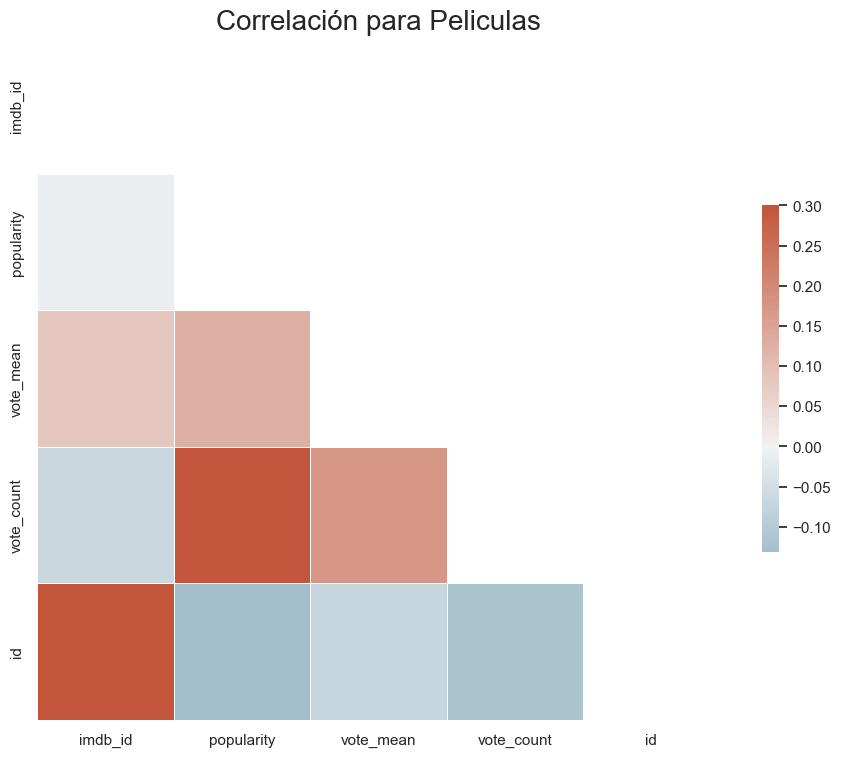

In [117]:
pl.correlations(
    movies3, 
    title='Correlación para Peliculas'
)

#### Popilarity

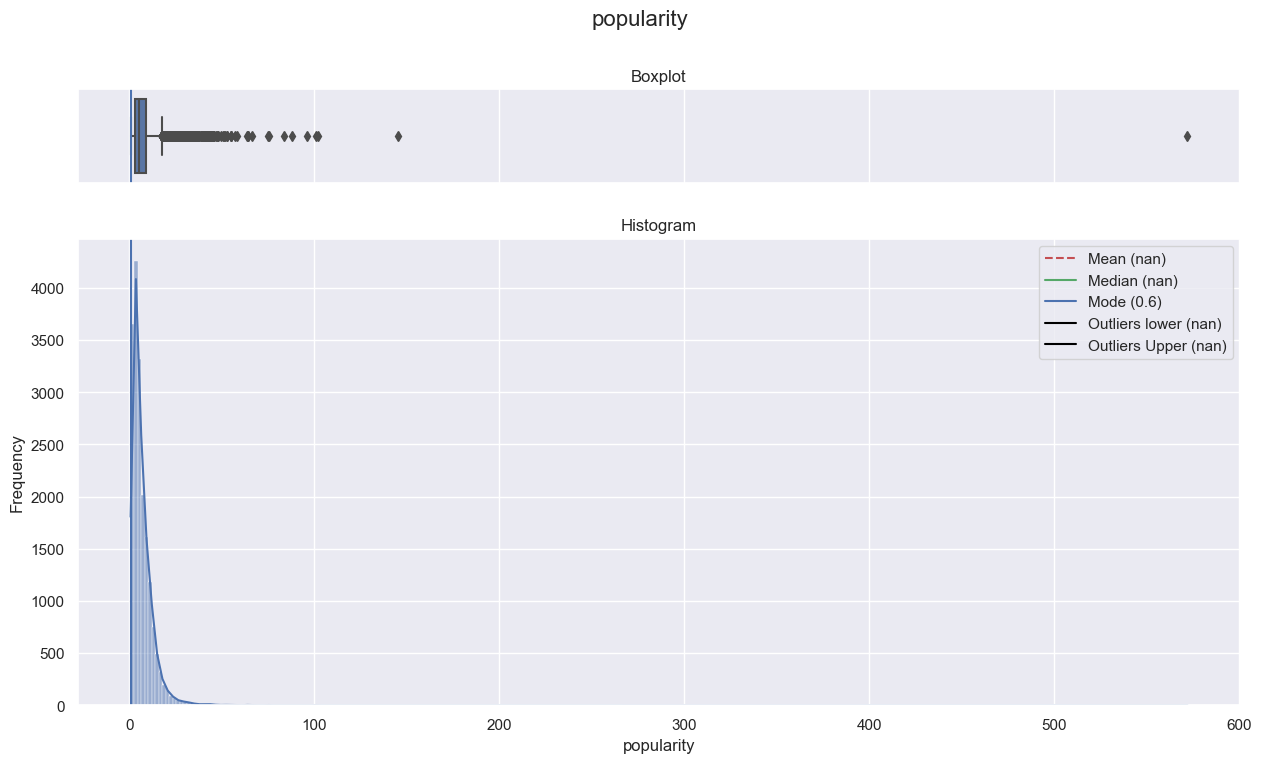

In [118]:
pl.l_size()
pl.describe_num_var(movies3, "popularity", bins=300)

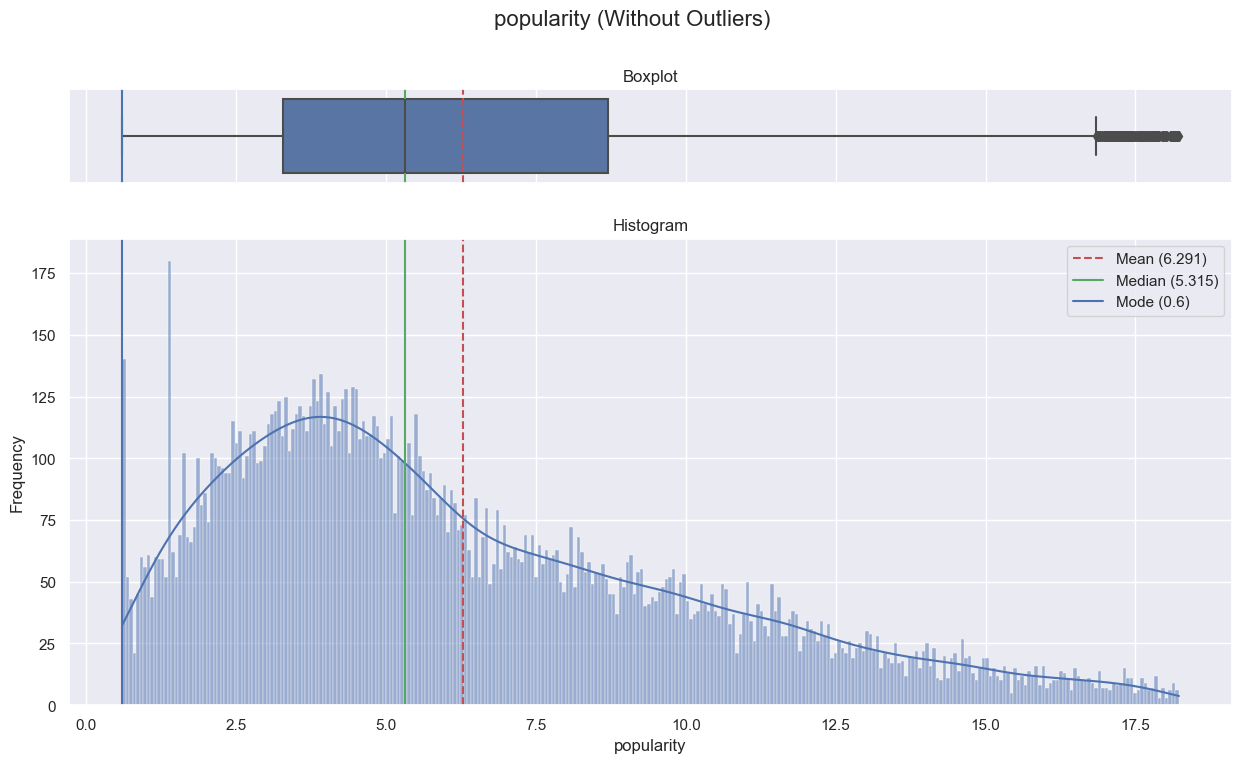

In [120]:
pl.describe_num_var(movies3.dropna(), "popularity", bins=300, remove_outliers=True)

**Observaciones**

* La popularidad mantiene la relación de una ley de potencias, donde pocas peliculas son muy populares siendo en su mayoria valores atipicos, por encima de bigote superior o maximo y muchas peliculas tiene valores bajs de popularidad.
* Si quitams todos los valores > Q3+1.5*IQR y < Q1-1.5*IQR vemos con mas claridad una distribucion sesgadda a derecha y por ende la mediana y media a izquierda.
* La mode se encuetra en el cero. Esto nos dice que la mayoria de peliculas tiene popularidad cero.

### For Adults

¿La pelicula esta catalogada para mayores de edad? 

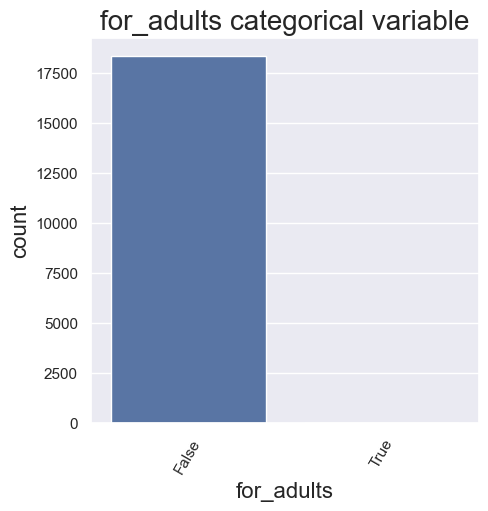

In [121]:
pl.s_size()
pl.describe_cat_var(movies3, "for_adults")

**Observaciones**

* Se aprecia que esta variable esta muy desbalanceada. 
* Ademas es inconsistente, ya que de 33.444 peliculas solo 6 son para adultos. Por esta cuestión esta columna no es apto para el entrenamiento y se decidio removerla.

### Release

Se refiere a la fecha de estreno de la pelicula.

In [122]:
movies3['release_year'] = movies3.release.dt.year

In [123]:
movies3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18350 entries, 0 to 18677
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            18350 non-null  int64         
 1   title              18350 non-null  object        
 2   genres             18350 non-null  object        
 3   for_adults         18350 non-null  bool          
 4   original_language  18350 non-null  object        
 5   overview           18350 non-null  object        
 6   poster             16479 non-null  object        
 7   release            18350 non-null  datetime64[ns]
 8   popularity         18349 non-null  float64       
 9   vote_mean          18350 non-null  float64       
 10  vote_count         18350 non-null  int64         
 11  tags               18350 non-null  object        
 12  id                 18350 non-null  int64         
 13  release_year       18350 non-null  int32         
dtypes: bool(1),

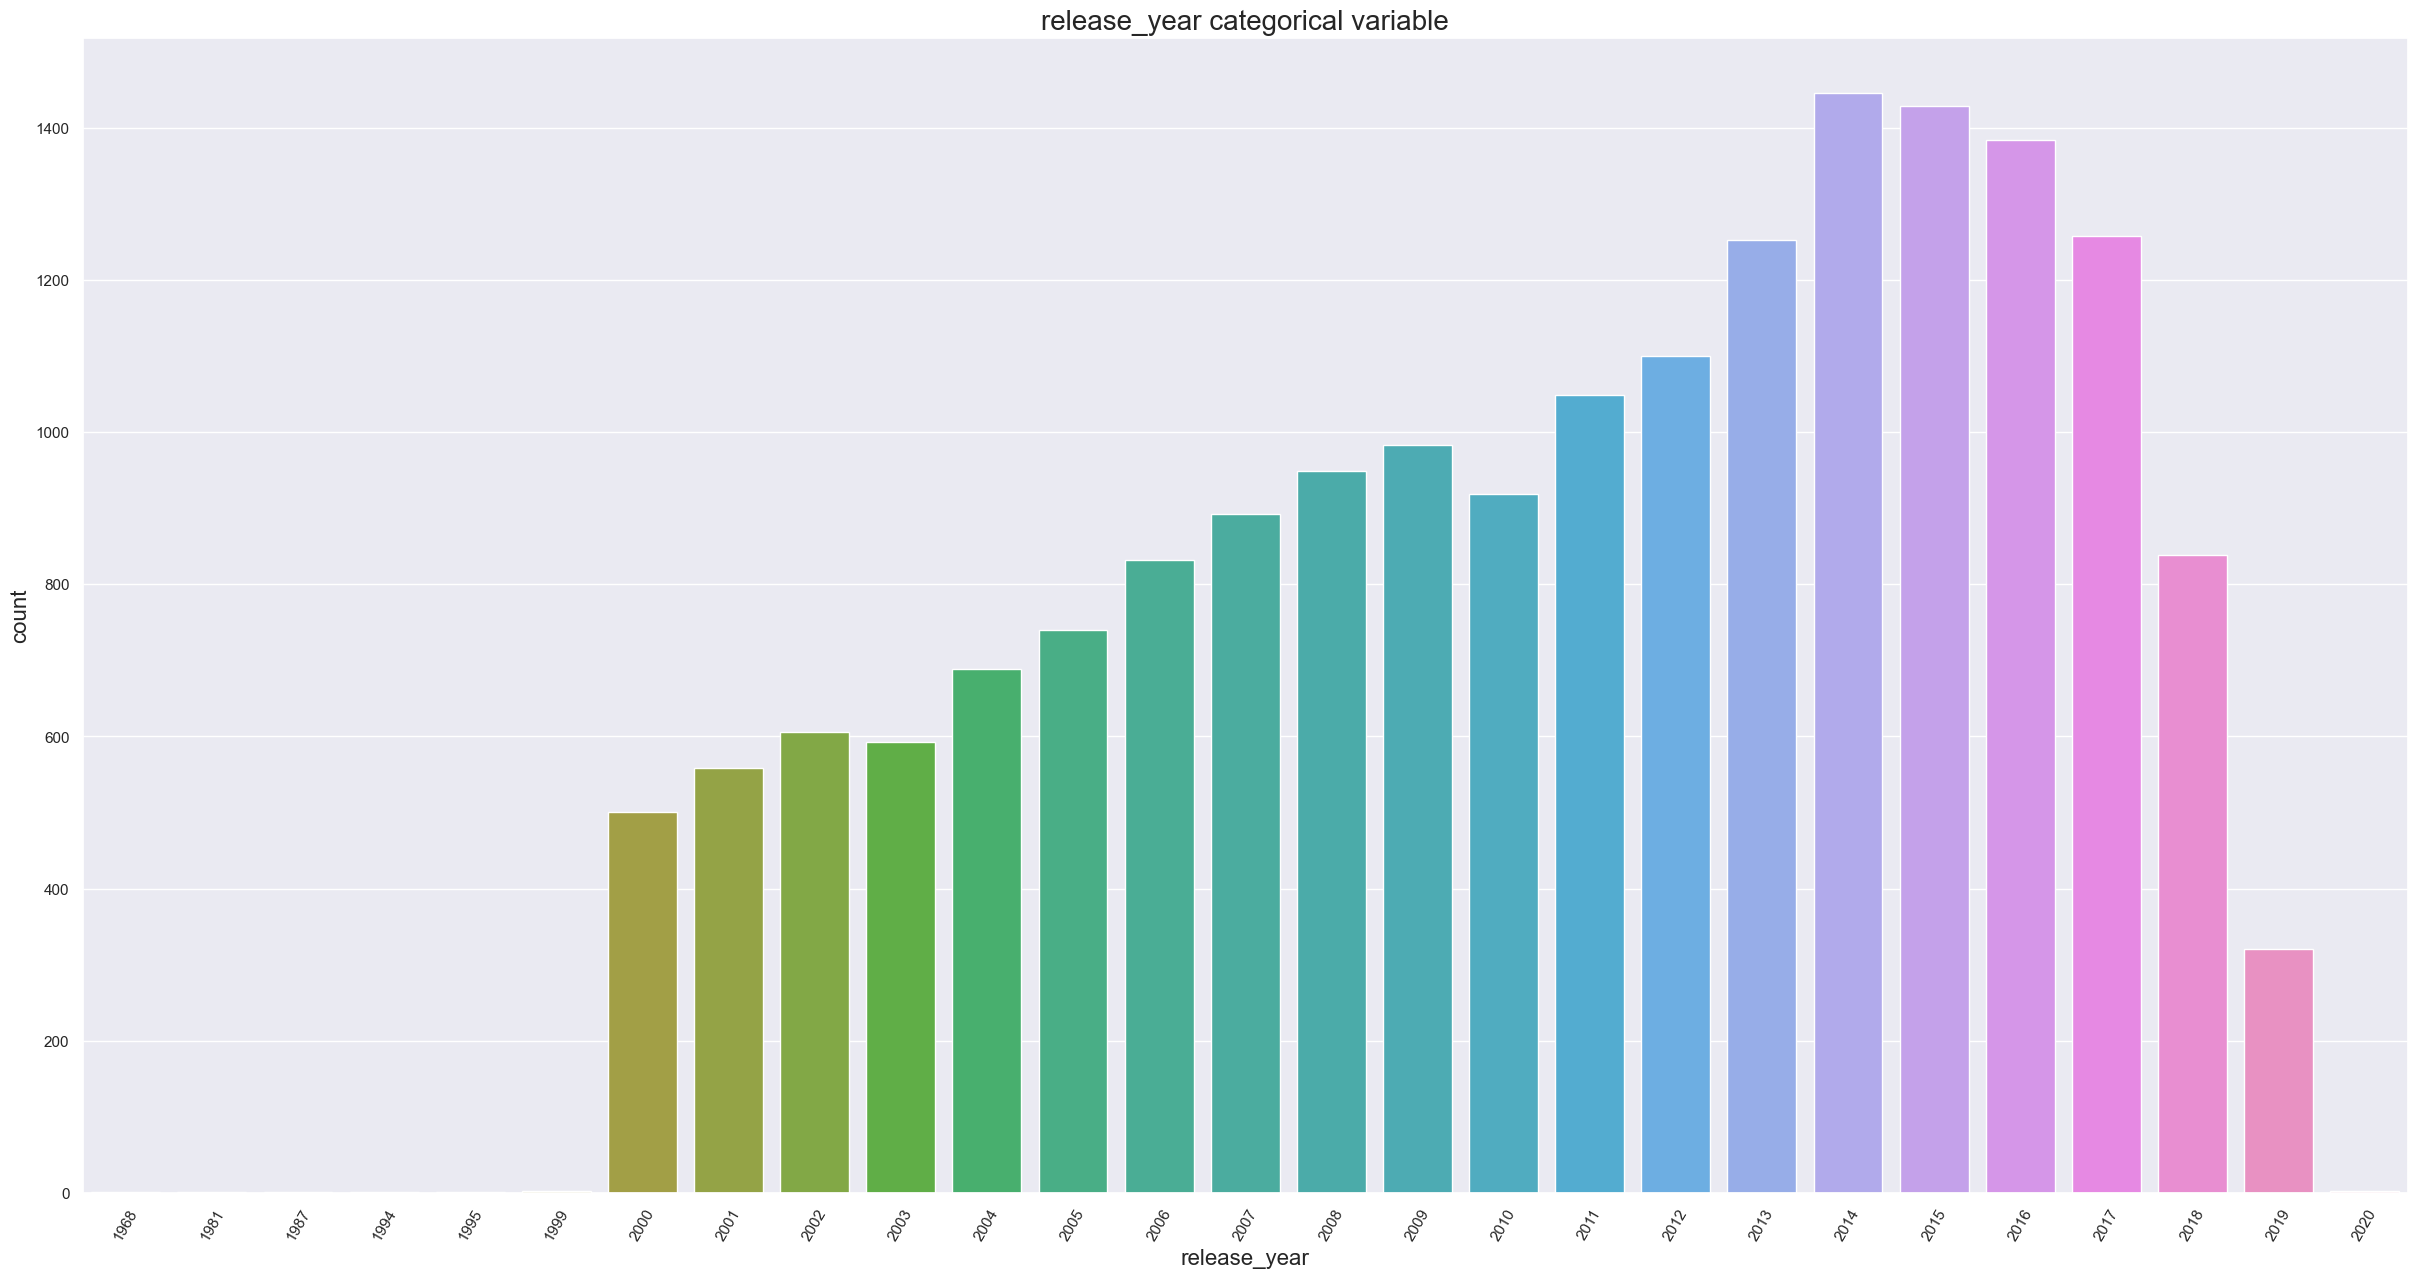

In [124]:
pl.xxl_size()
pl.describe_cat_var(movies3, 'release_year', order_column='release_year')

**Observaciones**

* Acalramos que hay una icinsitencia de datos. Hay años como 2005 donde el primero de enero tiene todos los estrenso de año y otros deonde los estrenos estan repartidos en varias fechas. Esto nos dice que es posible que en realidad este campo represente la cantidad de pelicula extrenada por año o bien que esa sea la cardinalidad real de los datos.
* Por otro lado en el grafico se aprecia que la cantidad de peliculas estrenada por año crese exponencialmente y 2017 baja lo cual seguramente es decido a que no se encuentra todo el año.
* A partor del 1994 se aprecia in el mayor crecimiento.

### Original Language

Se refiere al lenguage del audio original de la pelicula.

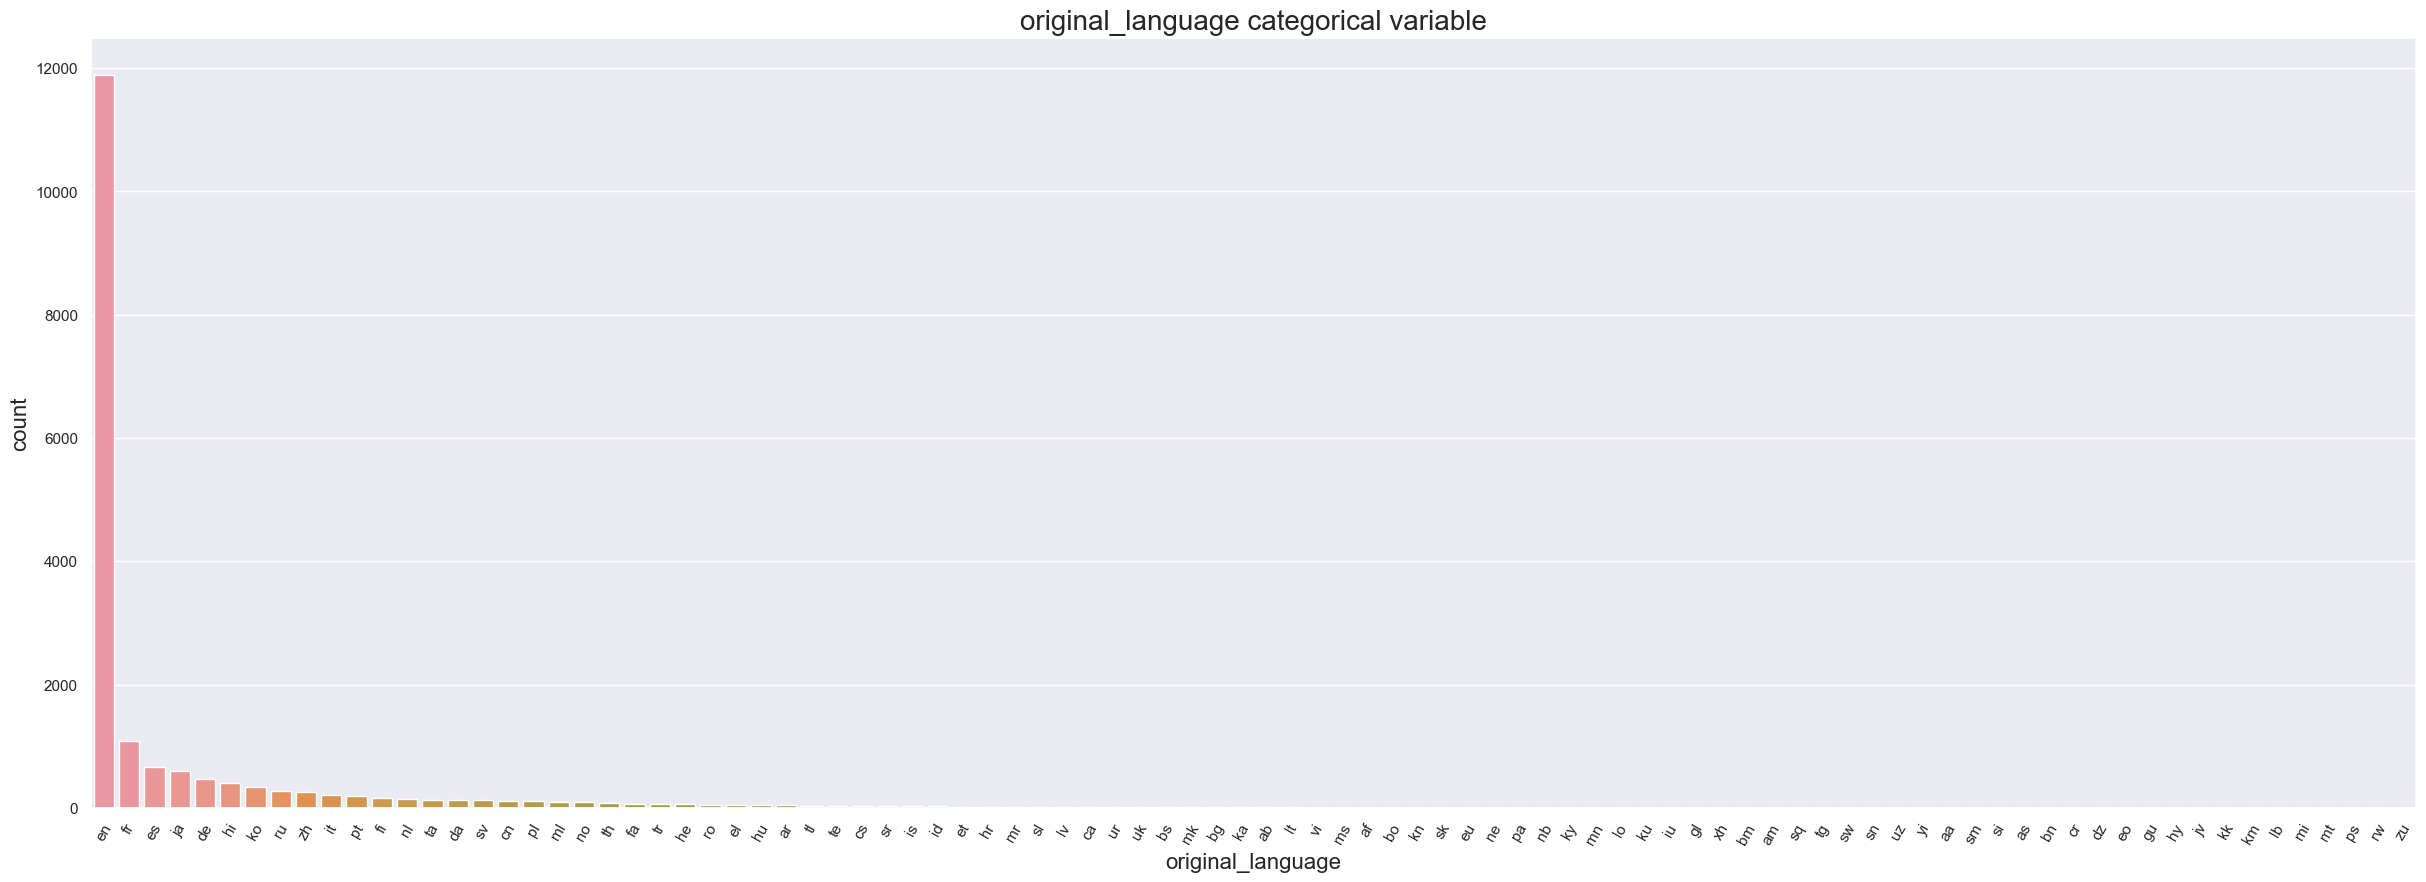

In [125]:
pl.xxl_flat_size()
pl.describe_cat_var(movies3, 'original_language')

**Observaciones**

* Es de esperar que el lenguage predominante sea el ingles.

!uitemos esta opcion y volvamos a graficas:

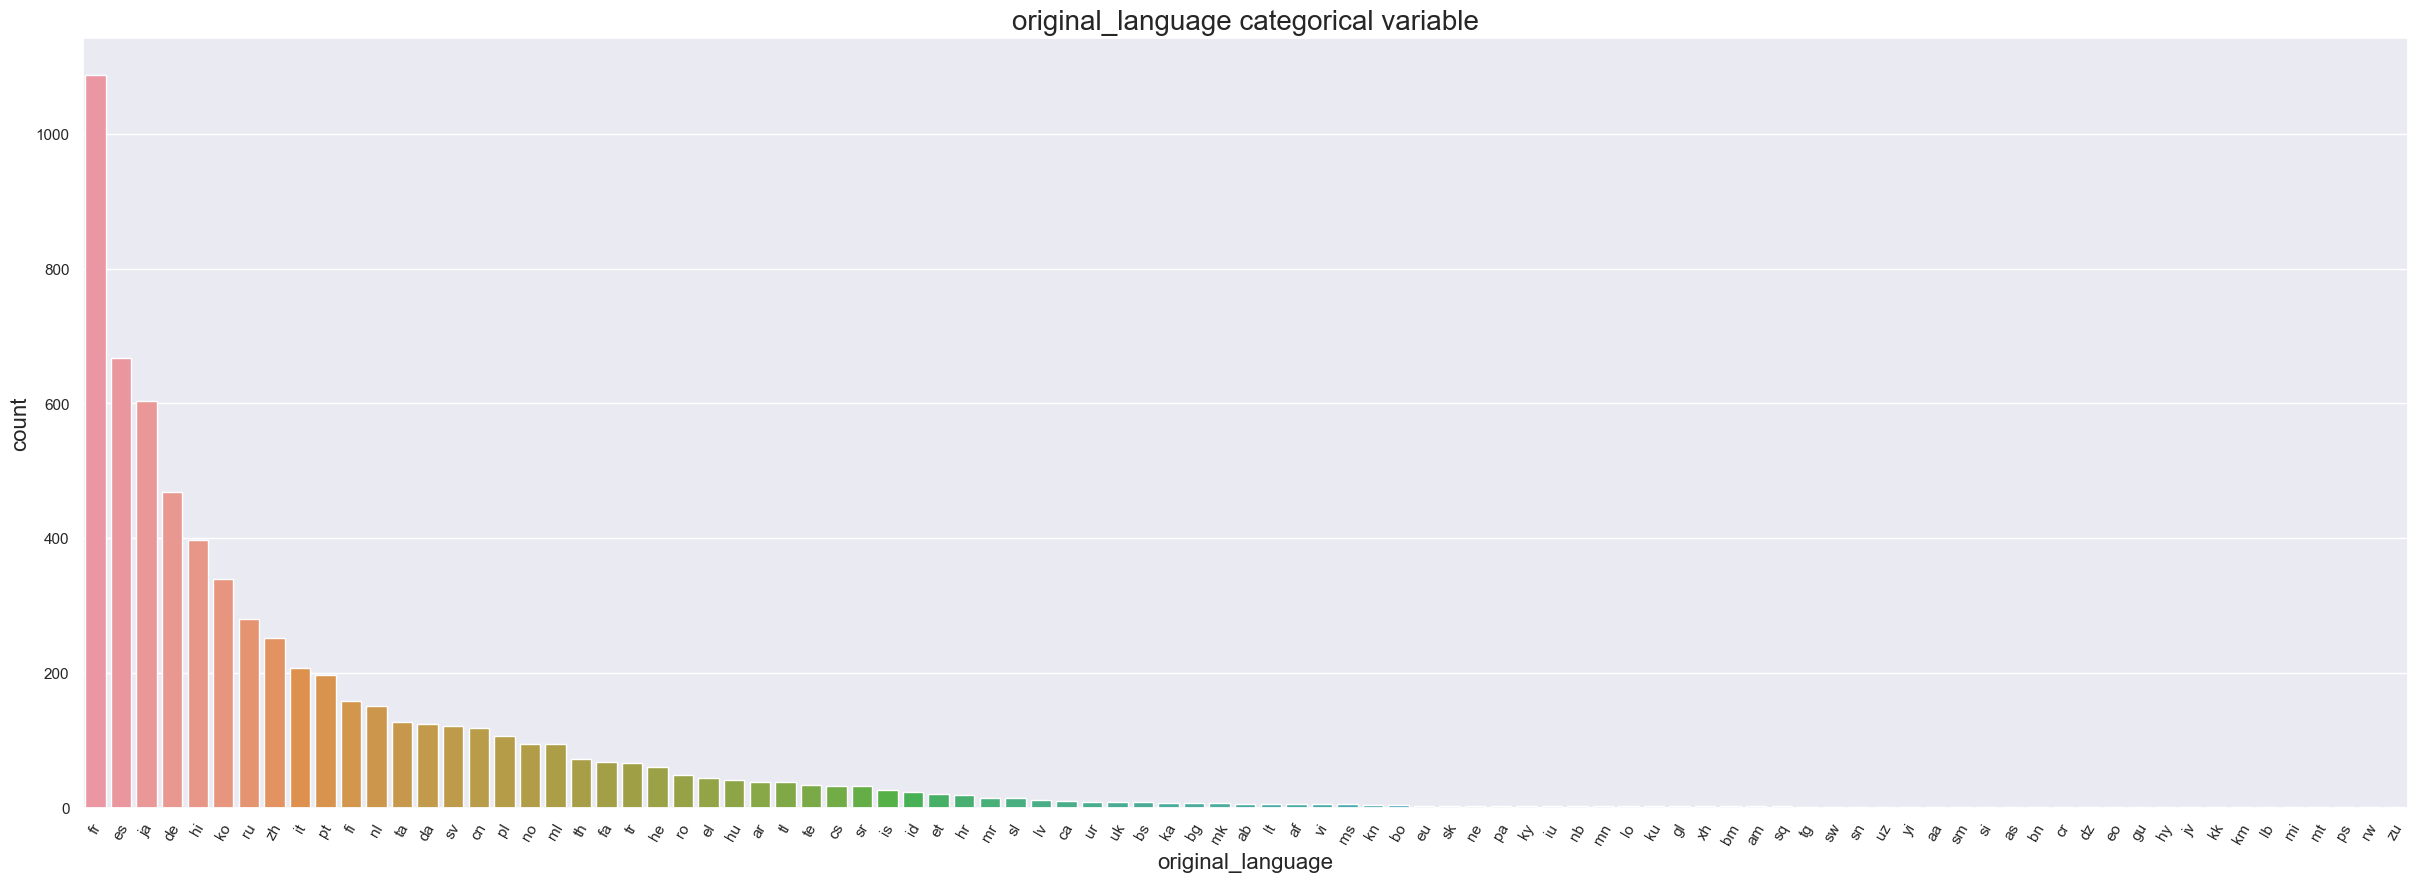

In [126]:
pl.xxl_flat_size()
pl.describe_cat_var(
    movies3[movies3['original_language'] != 'en'], 
    'original_language'
)

**Observaciones**

* Vemos que que los lenguajes frances, japones, italiana, aleman y español son los lenguages originales con mas mayor ferciencia. Eston indica indirectamente que son los paises con mas peso en el mundo sinematografico ademas de los paises de habla inglesa.

### Cantidad de votos

Representa la cantidad de votos o calificaciones que recibio la pelicula en el dataset en the movie database.

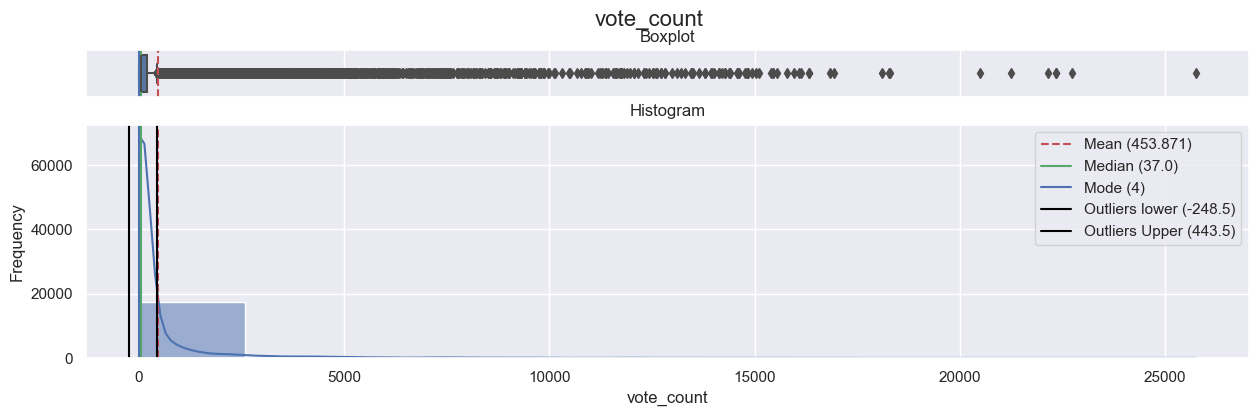

In [127]:
pl.l_flat_size()
pl.describe_num_var(movies3, "vote_count", bins=10)

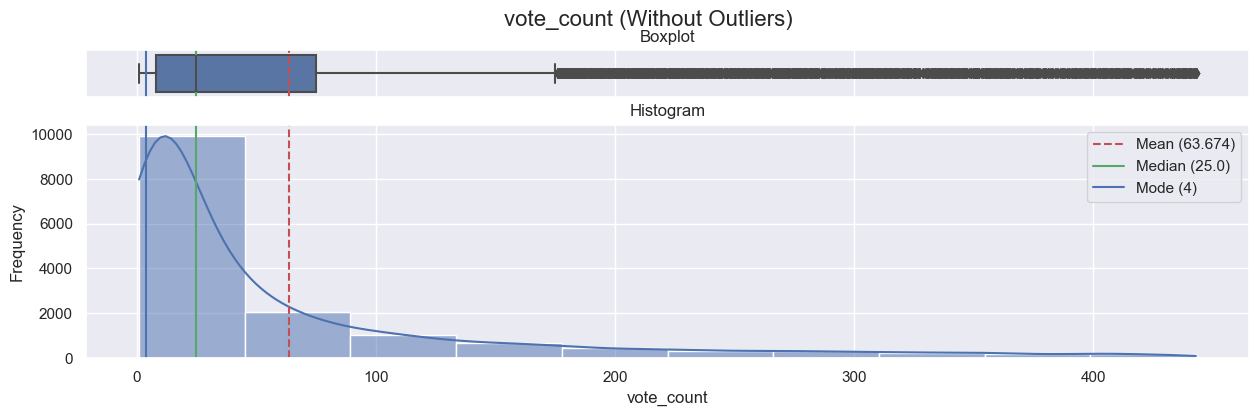

In [128]:
pl.describe_num_var(movies3, "vote_count", bins=10, remove_outliers=True)

### Tags

Esta columna tiene un conjunto sin repeticion de los tagas agragrados por todos los auaurios que calificaron una pelicula. Cada tag es una palabra o conunto de palabras. A continuacion se grafica una nube de palabras para visualiazr la freciencia relativa de las palabras que comonen los tagas:

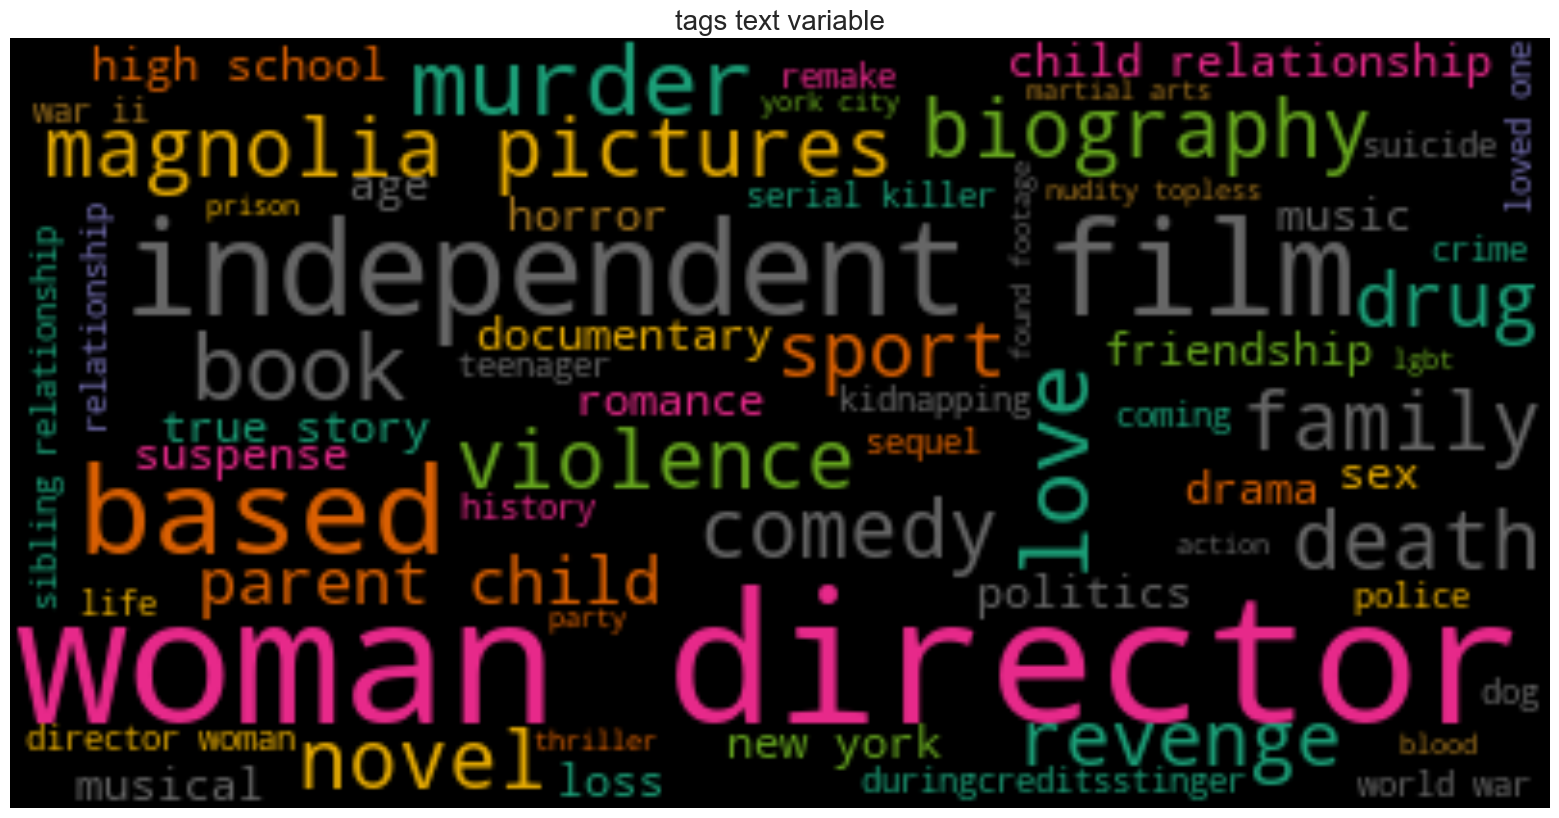

In [129]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'tags', flatten=True)

### Overview

La variable overview contiene la reseña o un resumen de la pelicula. Al igual qeu la variable tagas graficamos una nube de palabras para visualizar la freciencia relativa de las mismas:

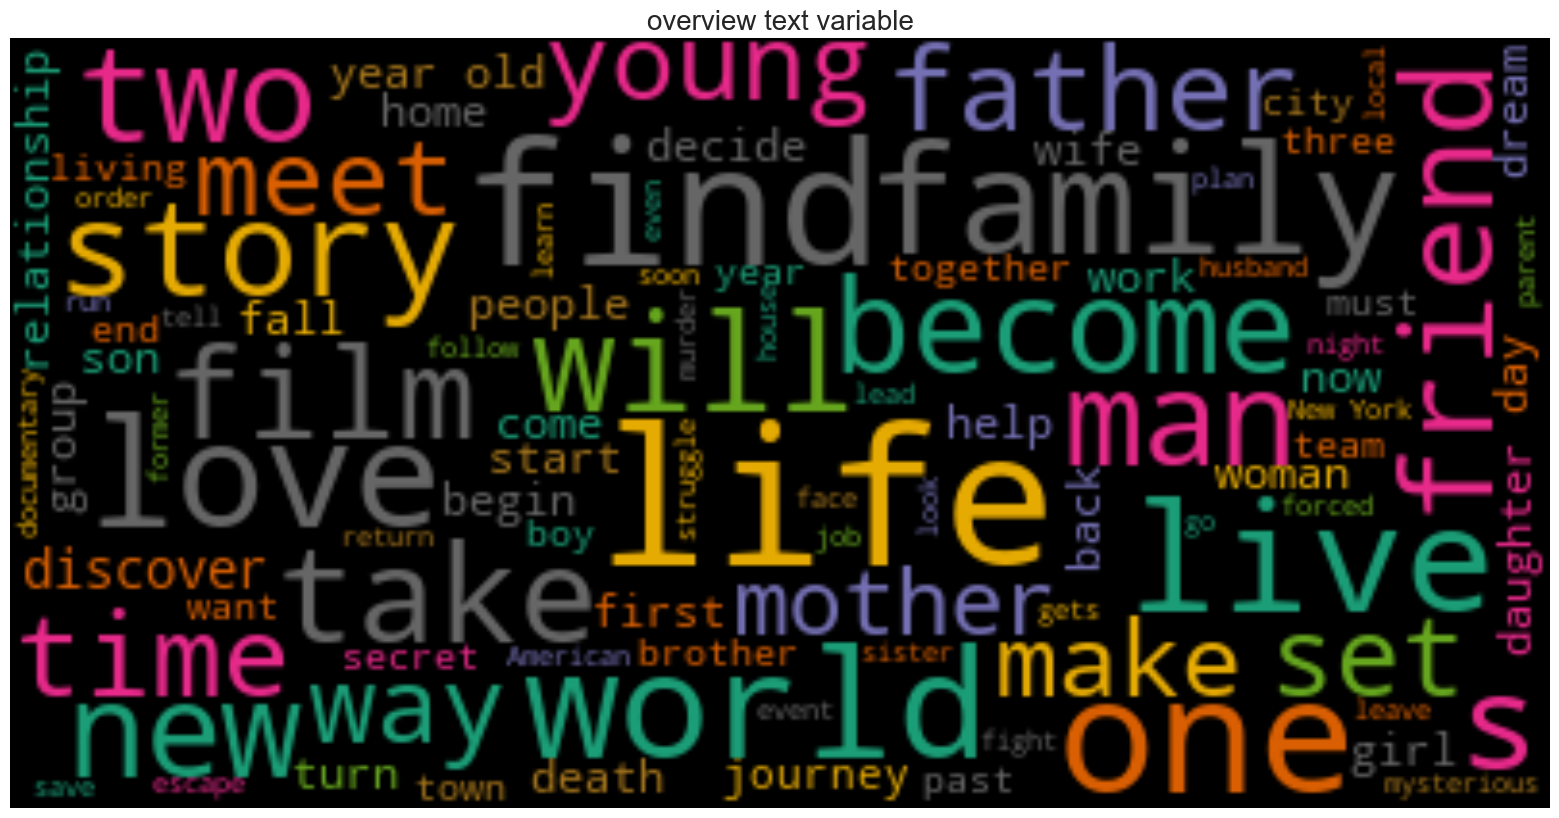

In [130]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'overview')

## Title

Esta varaible reprsenta el titulo de una pelicula. A continuacion nuevamente graficamos la frecuenia relativa de las palabar que componen todos los titulos del dataset:

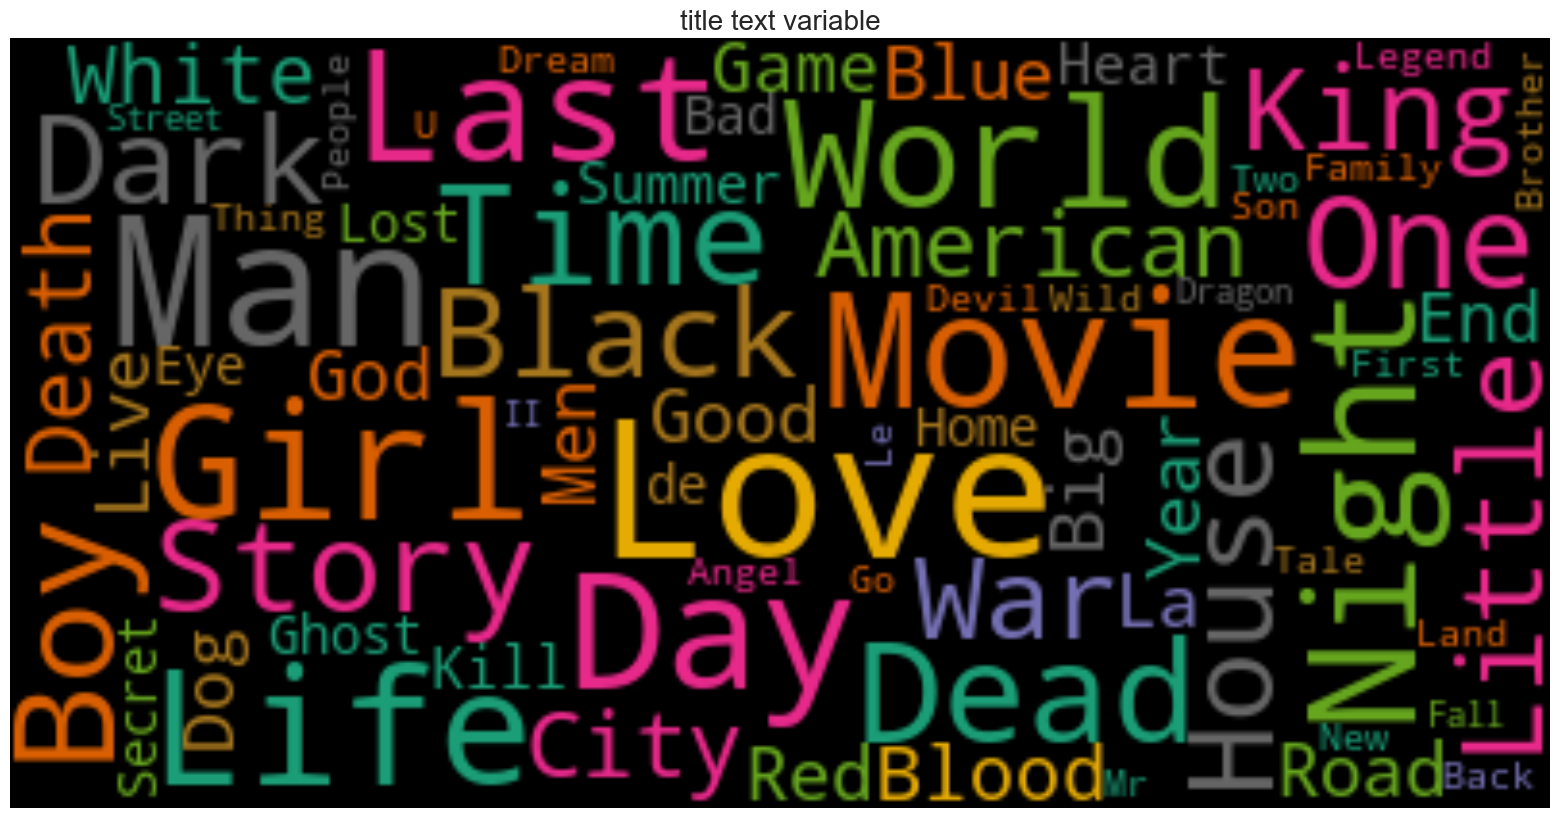

In [131]:
pl.xxl_flat_size()
pl.describe_text_var(movies3, 'title')

## Interactions

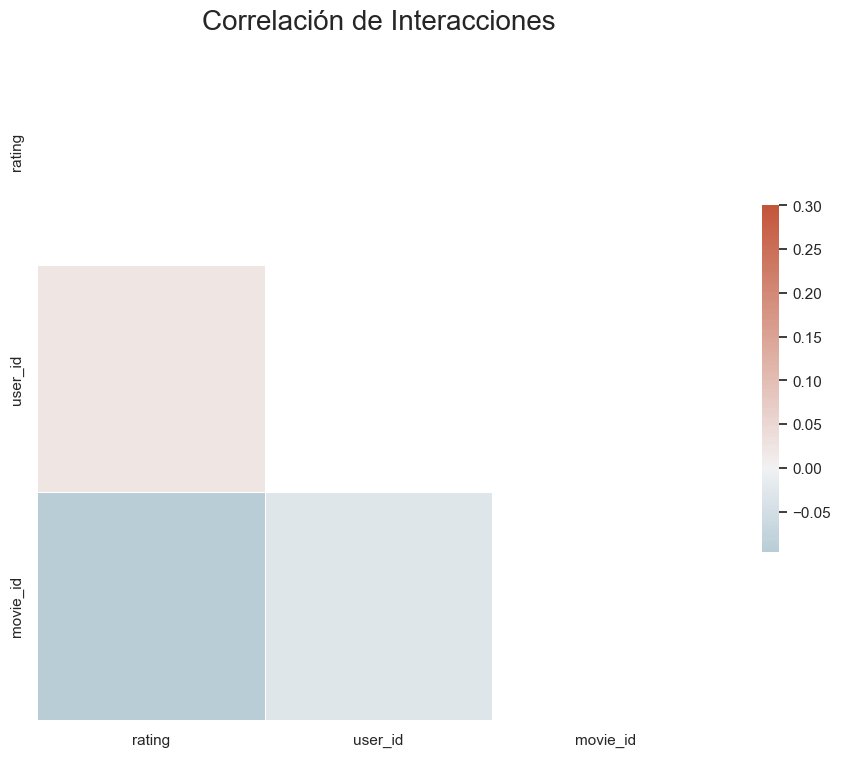

In [132]:
pl.correlations(
    interactions, 
    title='Correlación de Interacciones'
)

### Rating

In [133]:
dt.group_by(interactions, 'rating')

rating  count
7     4.0  49438
9     5.0  37157
6     3.5  34047
8     4.5  32330
5     3.0  25186
4     2.5  11889
3     2.0   8924
2     1.5   4225
1     1.0   3923
0     0.5   3606

Veamos la distribución de la calificaciones de la peliculas realizadas por los usaurio para todo el periodo del dataset:

In [134]:
years_range = (interactions['timestamp'].min().strftime("%Y-%m"), interactions['timestamp'].max().strftime("%Y-%m"))
years_range

('1997-09', '2019-11')

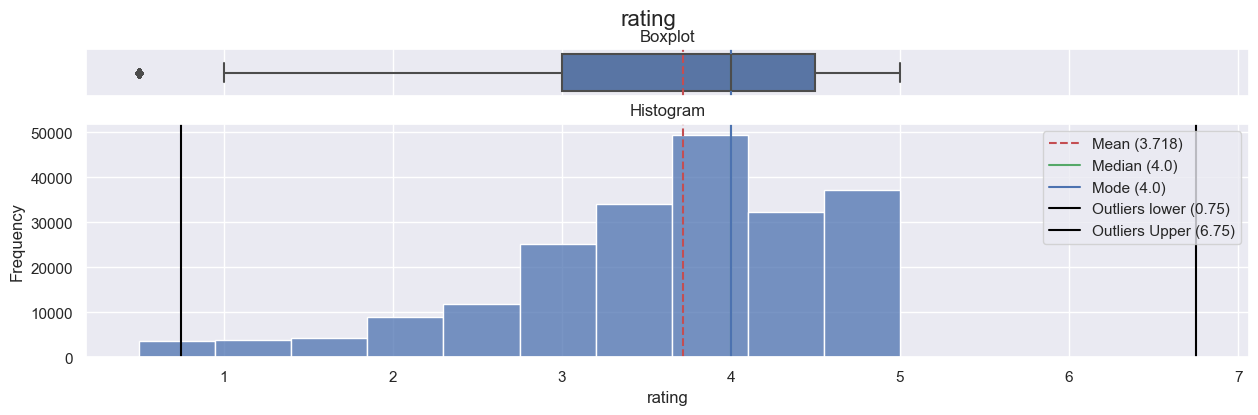

In [135]:
pl.l_flat_size()
pl.describe_num_var(interactions, "rating", bins=10, density=False)

Ahora veamos como cambia la distribucion del rating a través de los años:

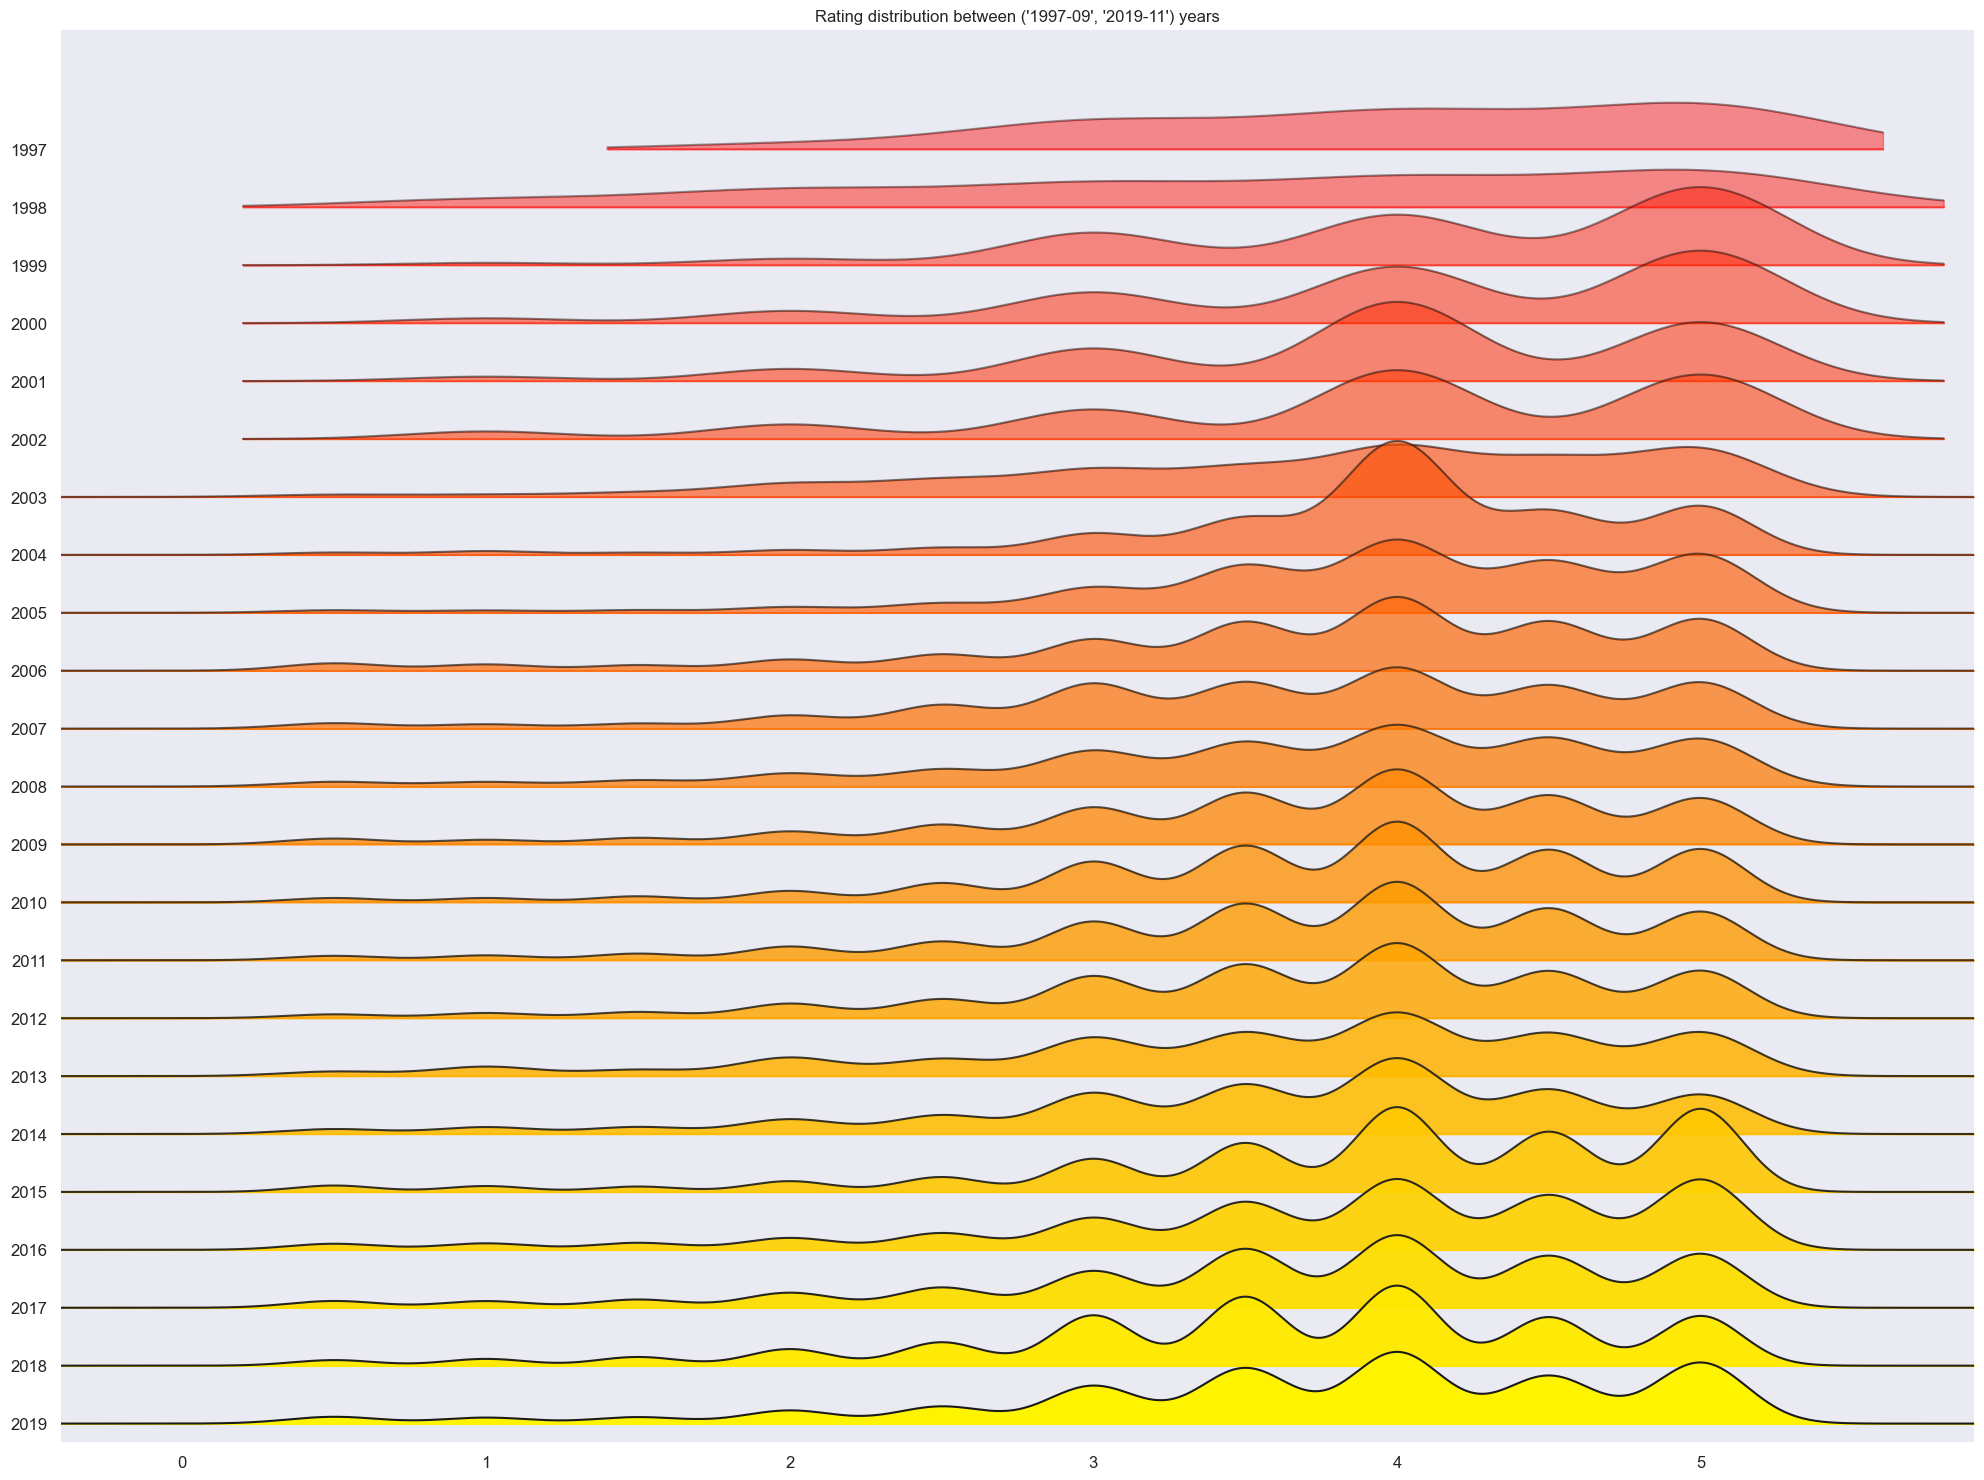

In [136]:
interactions['year'] = interactions.timestamp.dt.year

pl.xl_size()
pl.ridgeplot(
    interactions, 
    by     = 'year', 
    column = 'rating', 
    title  = f'Rating distribution between {years_range} years',
    kind   = 'kde',
)

# Peliculas y interacciones

# Correlaciones

In [137]:
complete_data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    )
complete_data = complete_data.loc[:, complete_data.columns!='id']
complete_data = complete_data.loc[:, complete_data.columns!='year']


complete_num_data = complete_data \
    .select_dtypes(include=np.number)

norm_complete_num_data = ut.norm(complete_num_data).drop(columns=['imdb_id'])

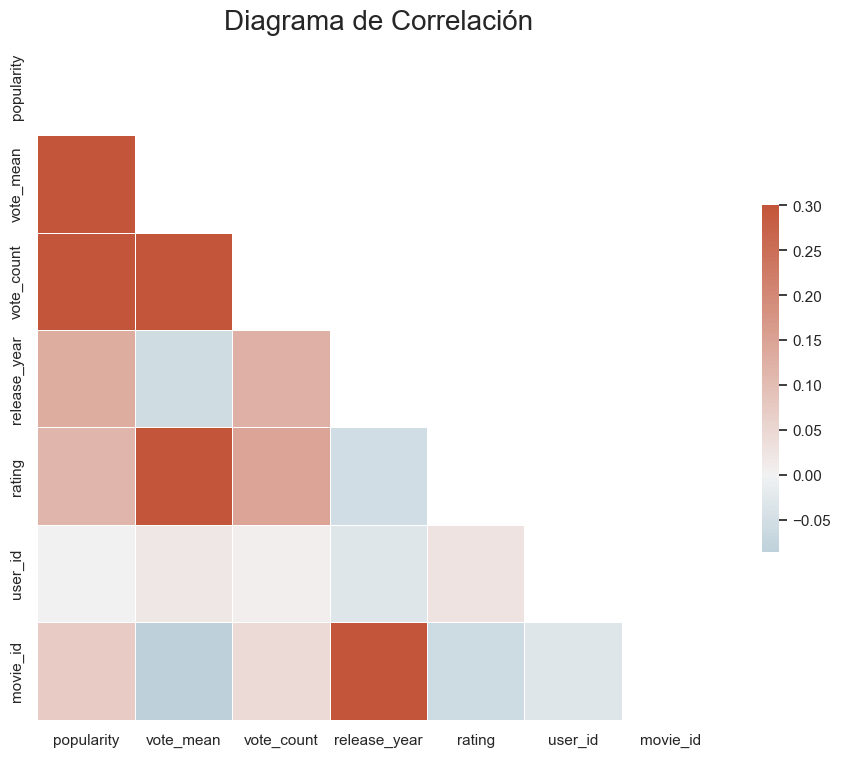

In [138]:
pl.correlations(norm_complete_num_data)

/opt/homebrew/Caskroom/miniconda/base/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/thesis/lib/python3.11/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)
/opt/homebrew/Caskroom/miniconda/base/envs/thesis/lib/python3.11/site-packag

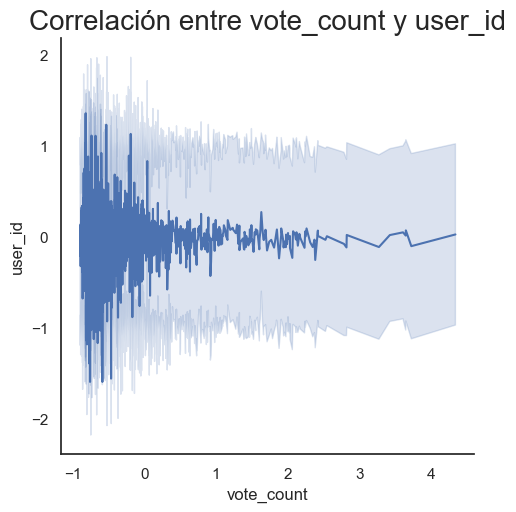

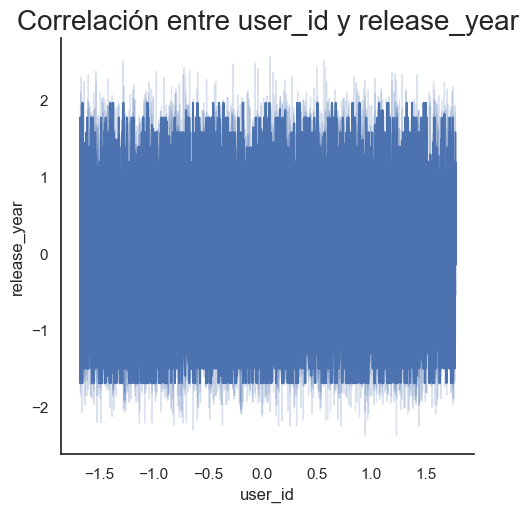

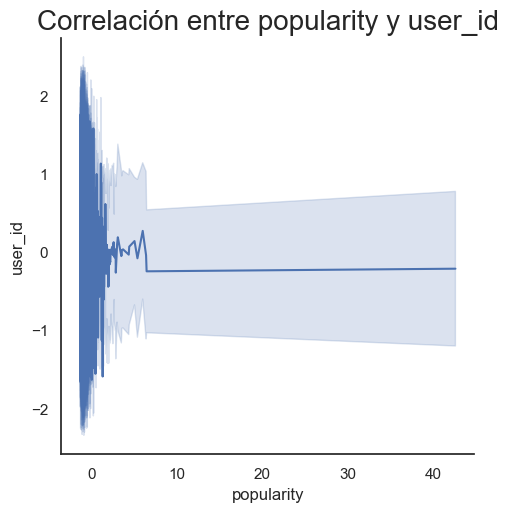

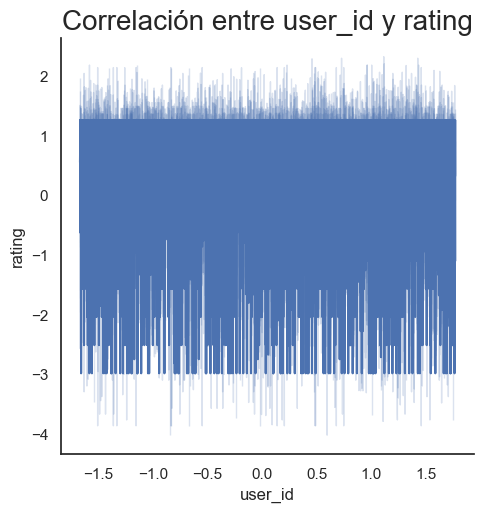

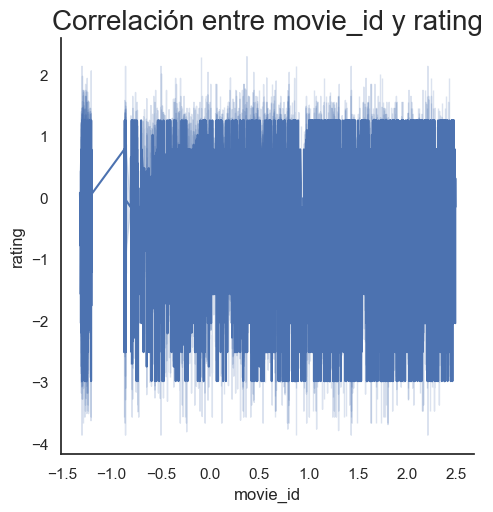

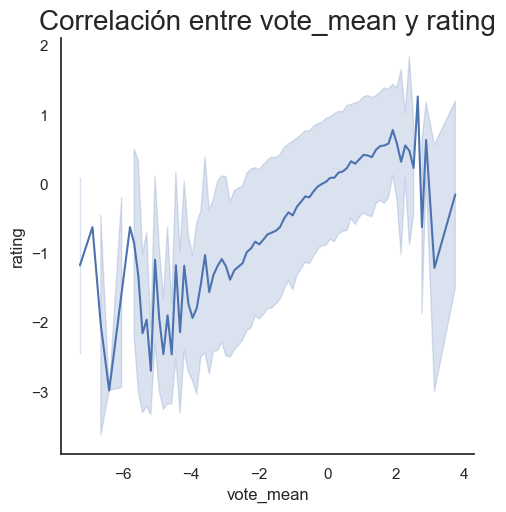

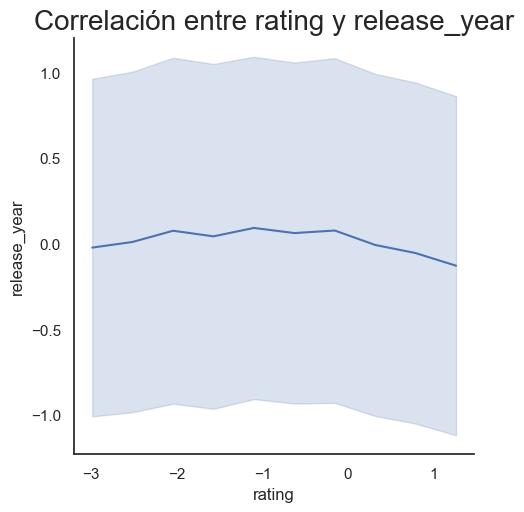

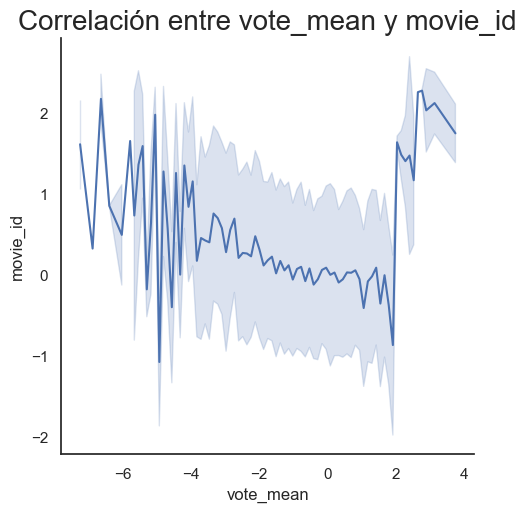

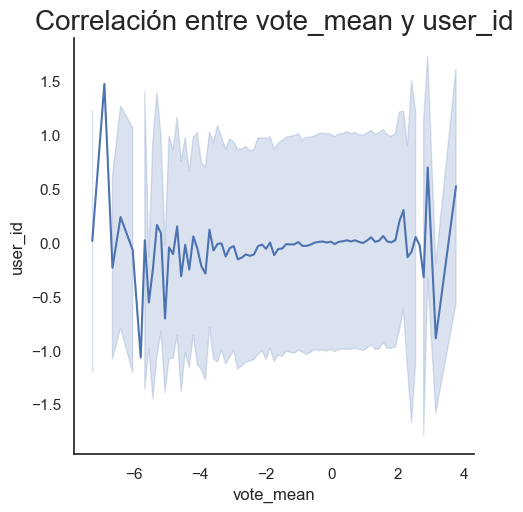

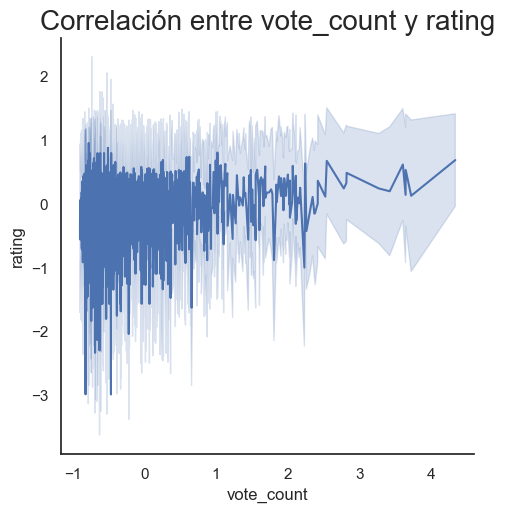

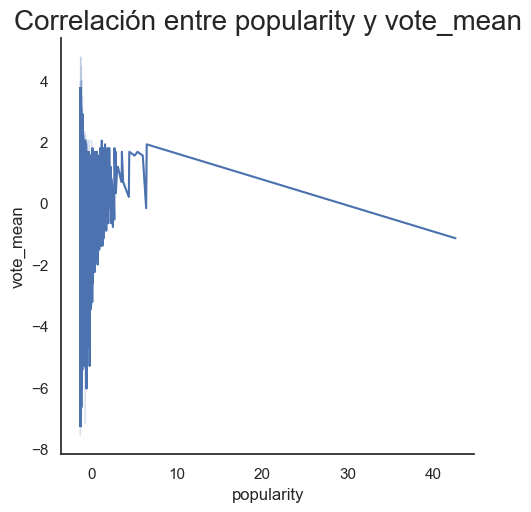

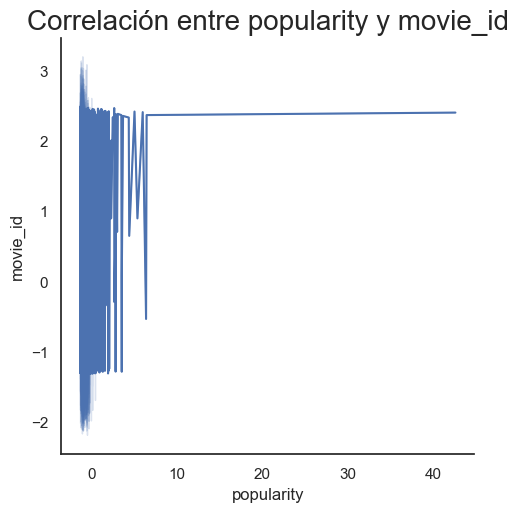

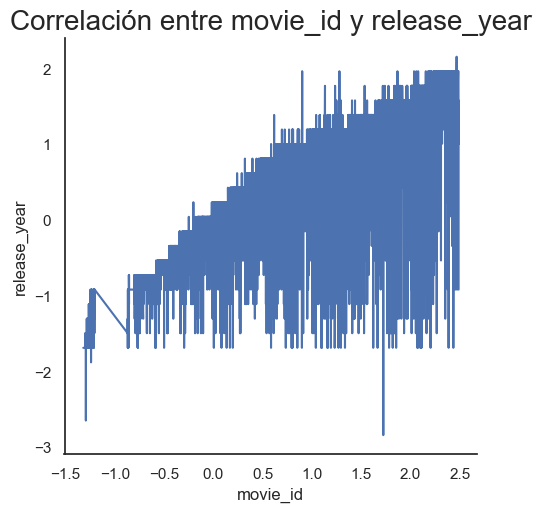

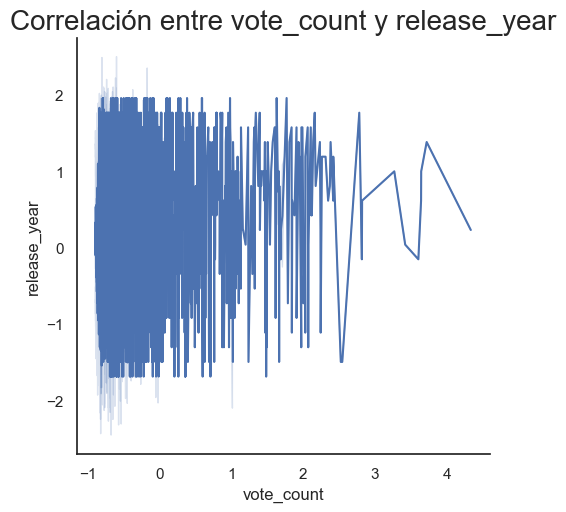

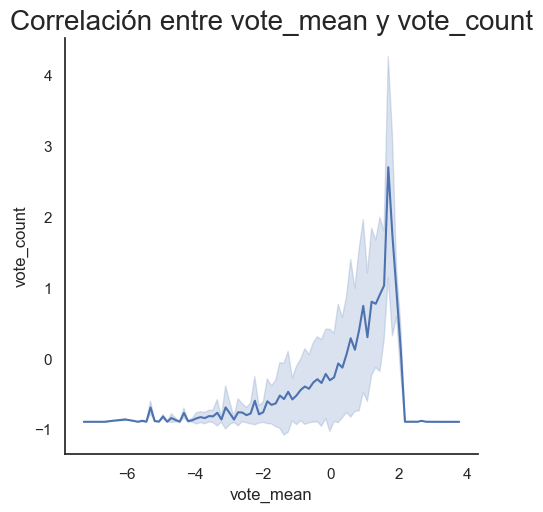

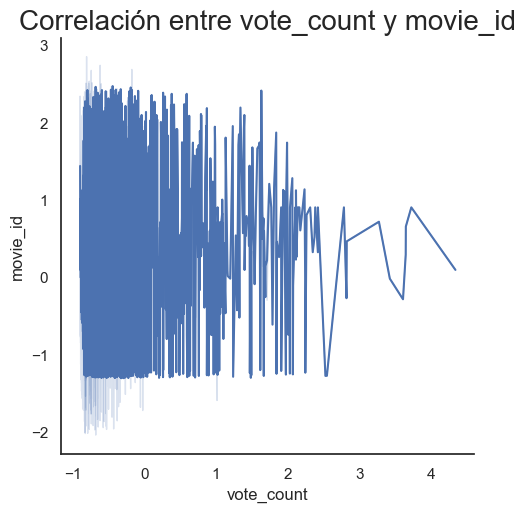

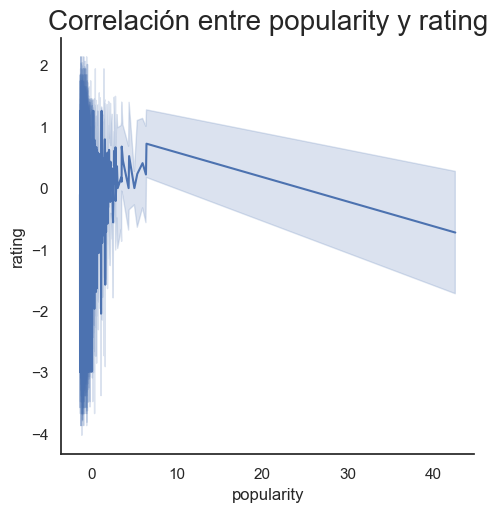

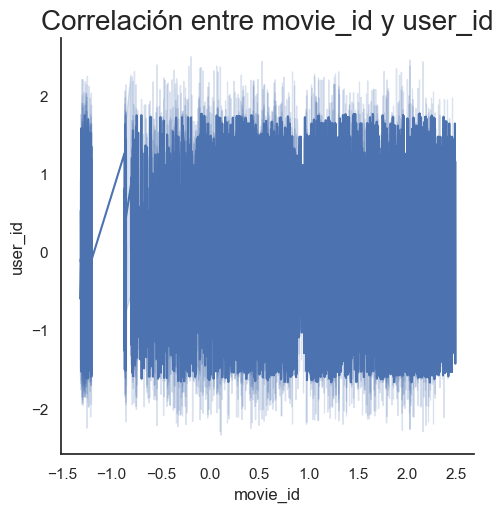

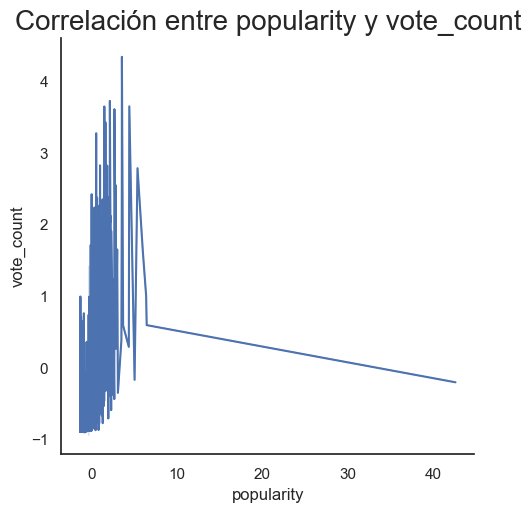

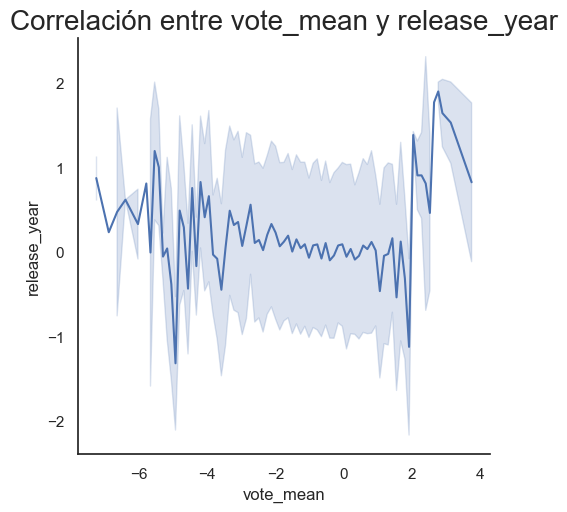

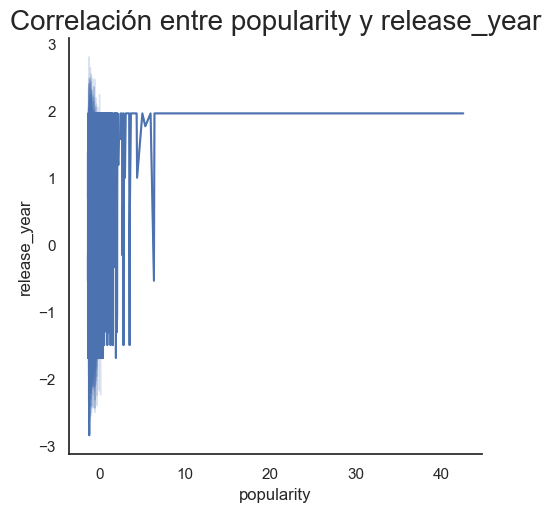

In [139]:
pl.plot_correlations(norm_complete_num_data)

# Componentes Principales

In [141]:
clusters = {
    0.5: '<2',
    1.0: '<2',
    1.5: '<2',

    2.0: '2-3.5',
    2.5: '2-3.5',
    3.0: '2-3.5',
    3.5: '2-3.5',

    4.0: '>4',
    4.5: '>4',
    5.0: '>4'
}


X  = norm_complete_num_data.dropna().copy().drop(columns=['rating'])
y  = complete_num_data.rating.apply(lambda x: clusters[x])

In [142]:
X

popularity  vote_mean  vote_count  release_year   user_id  movie_id
0        -0.630576  -0.770109   -0.849181     -1.687868 -1.199001 -1.319186
1        -0.630576  -0.770109   -0.849181     -1.687868  0.008403 -1.319186
2        -0.546314  -0.770109   -0.832524     -1.687868  1.621104 -1.311646
3        -0.546314  -0.770109   -0.832524     -1.687868 -0.353894 -1.311646
4        -0.546314  -0.770109   -0.832524     -1.687868 -1.532102 -1.311646
...            ...        ...         ...           ...       ...       ...
122570   -1.120754   0.208511   -0.891229      1.961802  1.641239  2.482315
122571   -0.641349   0.942477   -0.863806      1.961802 -1.427151  2.486344
122572   -1.337218   0.086184   -0.894886      1.001363  0.197893  2.487305
122573   -0.999787  -0.158471   -0.894073      1.577626 -0.633938  2.487564
122574   -1.063964  -0.770109   -0.891229     -0.919516  1.153582  2.487601

[122571 rows x 6 columns]

In [143]:
y.value_counts()

rating
>4       66462
2-3.5    48508
<2        7605
Name: count, dtype: int64

In [144]:
summary = dt.PCAAnalisys.make_on(X, y, n_components = 3)

In [145]:
summary.observations(indexes=[1,2])[:,0]

array([-2.18995121, -2.19994266, -2.15619997, ...,  0.06136755,
        0.3806895 , -0.85693654])

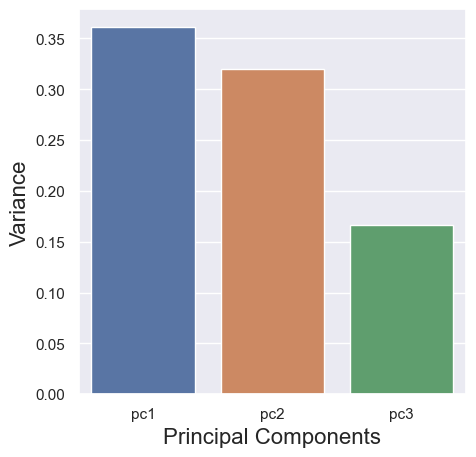

array([0.3607889 , 0.31967902, 0.16629281])

In [146]:
pl.s_size()
summary.plot_explained_variance()
summary.explained_variance()

2023-12-10 17:27:05,427 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2023-12-10 17:27:05,427 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


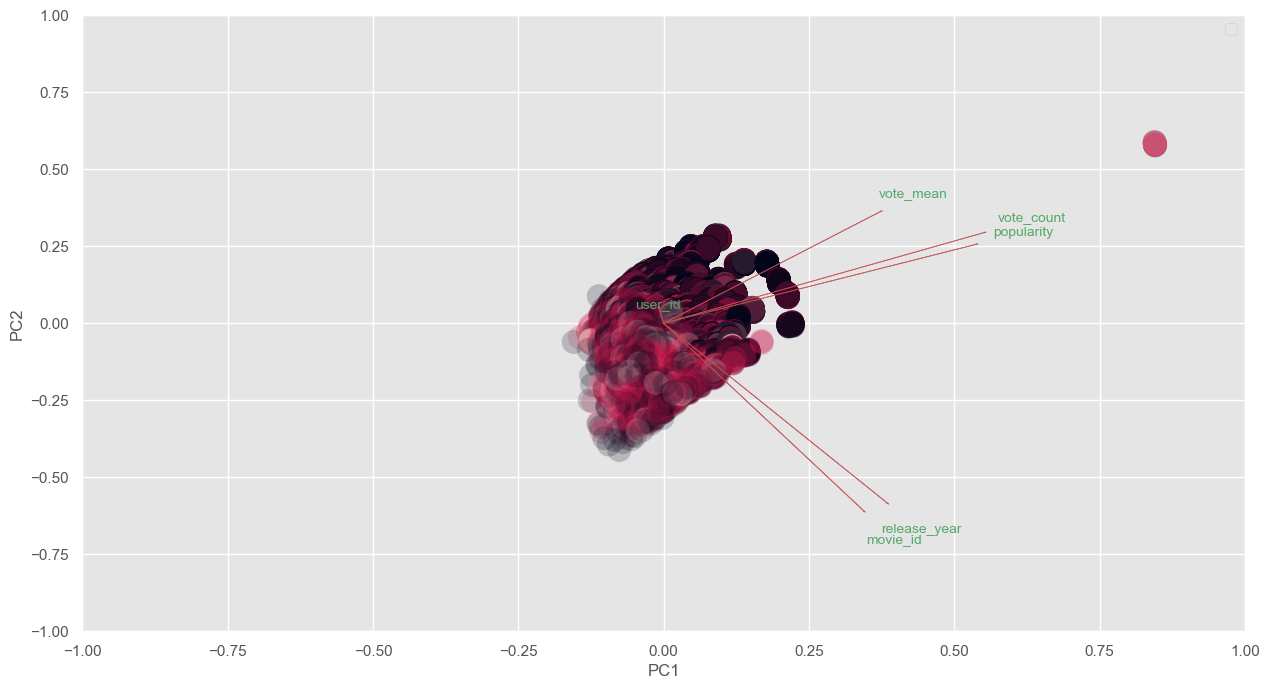

In [147]:
pl.l_size()
summary.biplot()

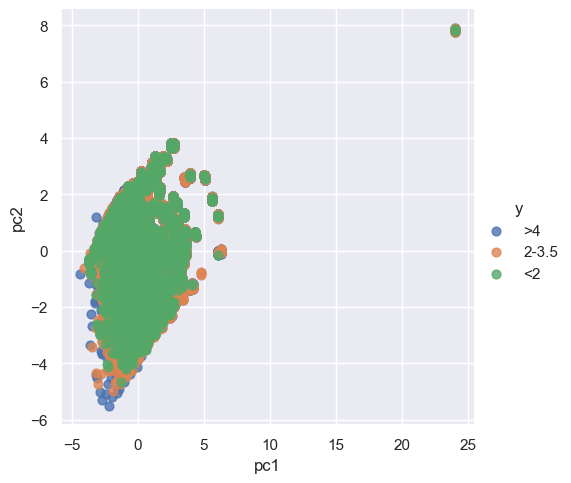

In [148]:
pl.l_size()
summary.plot_clusters()

## ¿Cuales son los generos de peliculas mas comunes?

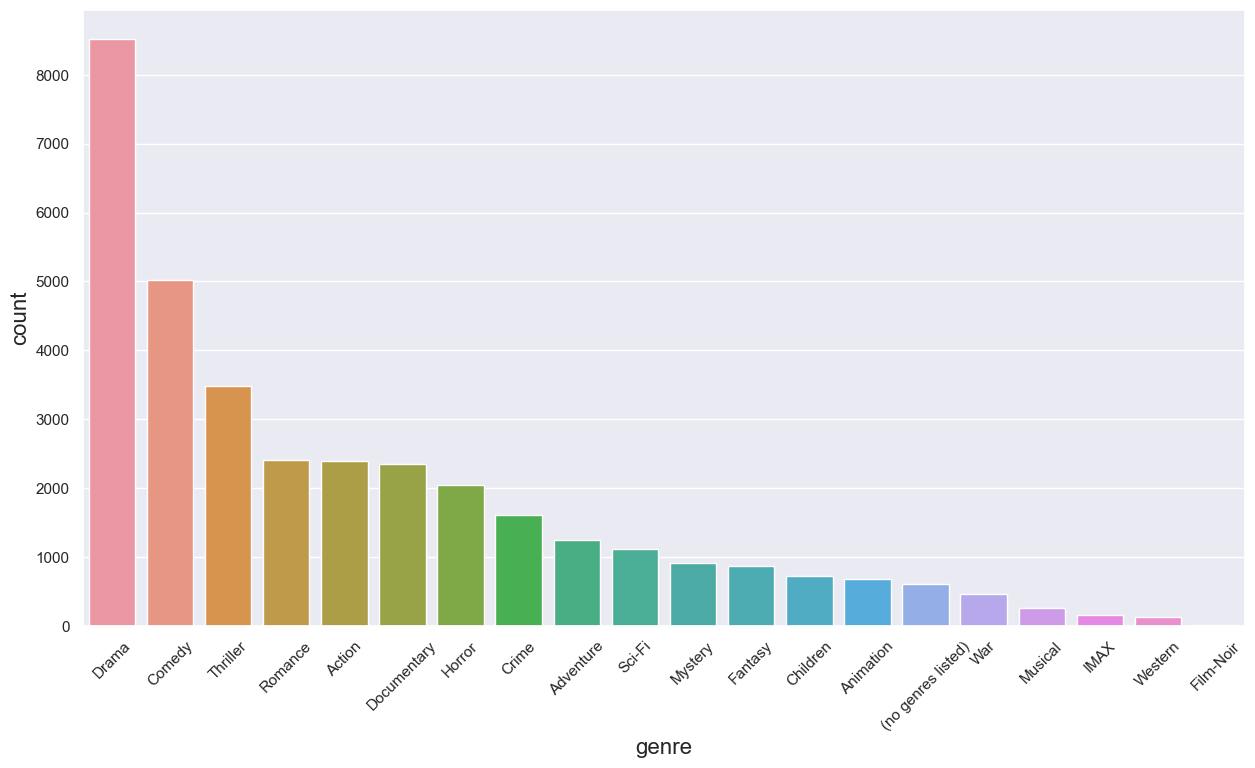

In [149]:
all_genres = lambda df: np.array([genre for genres in df['genres'].values for genre in genres])

genres_count = dt.frequency(all_genres(movies3),'genre')

pl.barplot(
    genres_count, 
    'genre', 
    'count', 
    figsize=(30, 6),
    x_rotation=45
)

## ¿Cuantas peliculas se estrenaron por año?

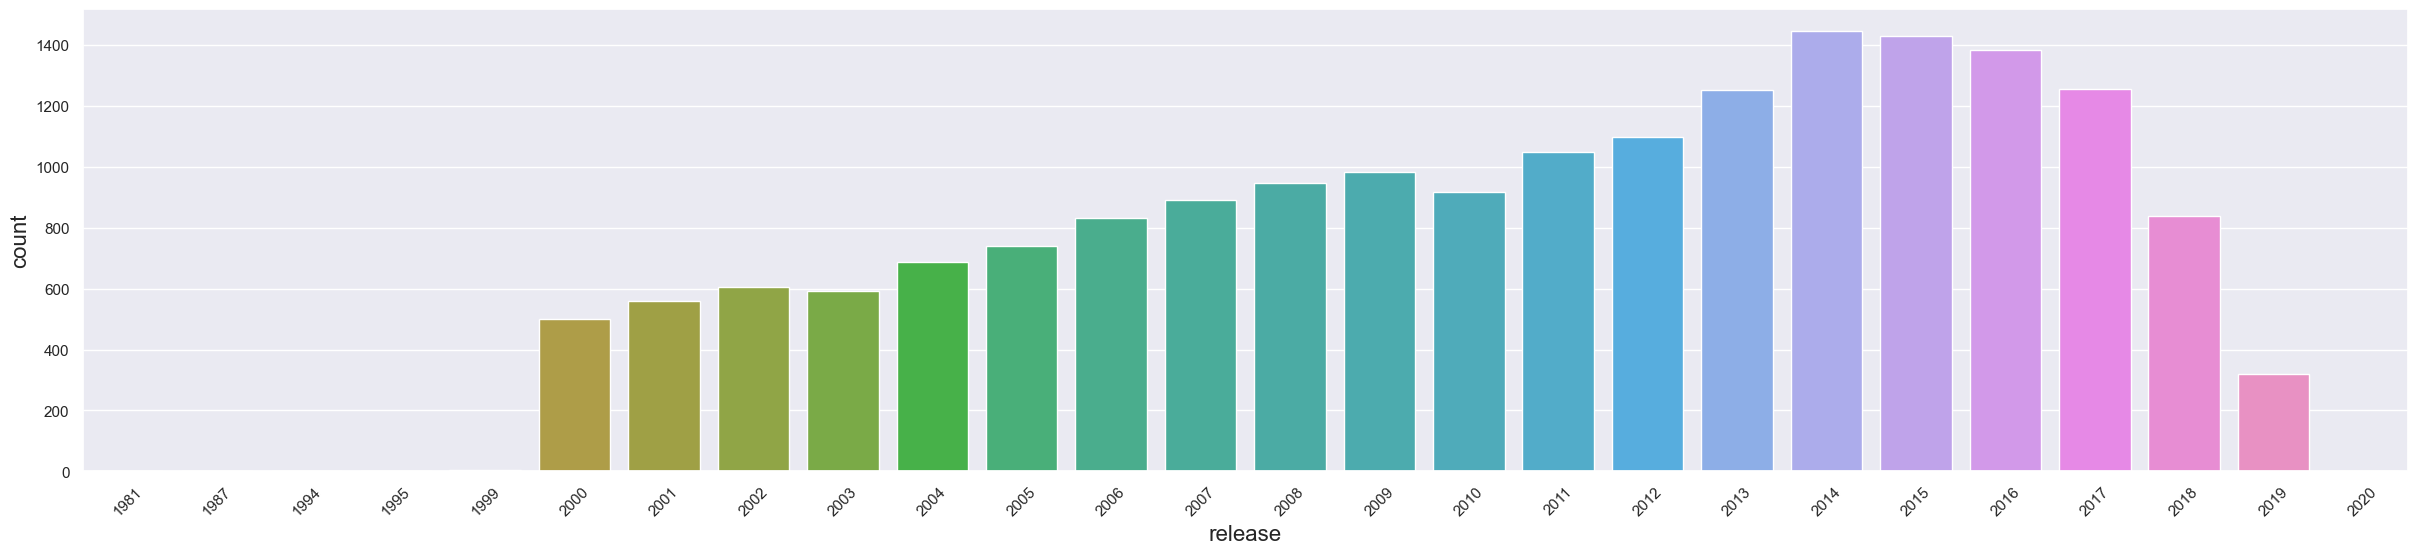

In [150]:
yearly_release_counts = movies3 \
    .groupby(movies3.release.dt.year) \
    .size() \
    .sort_values(ascending=False) \
    .reset_index(name='count')

pl.barplot(
    yearly_release_counts[yearly_release_counts.release >= 1970], 
    'release', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

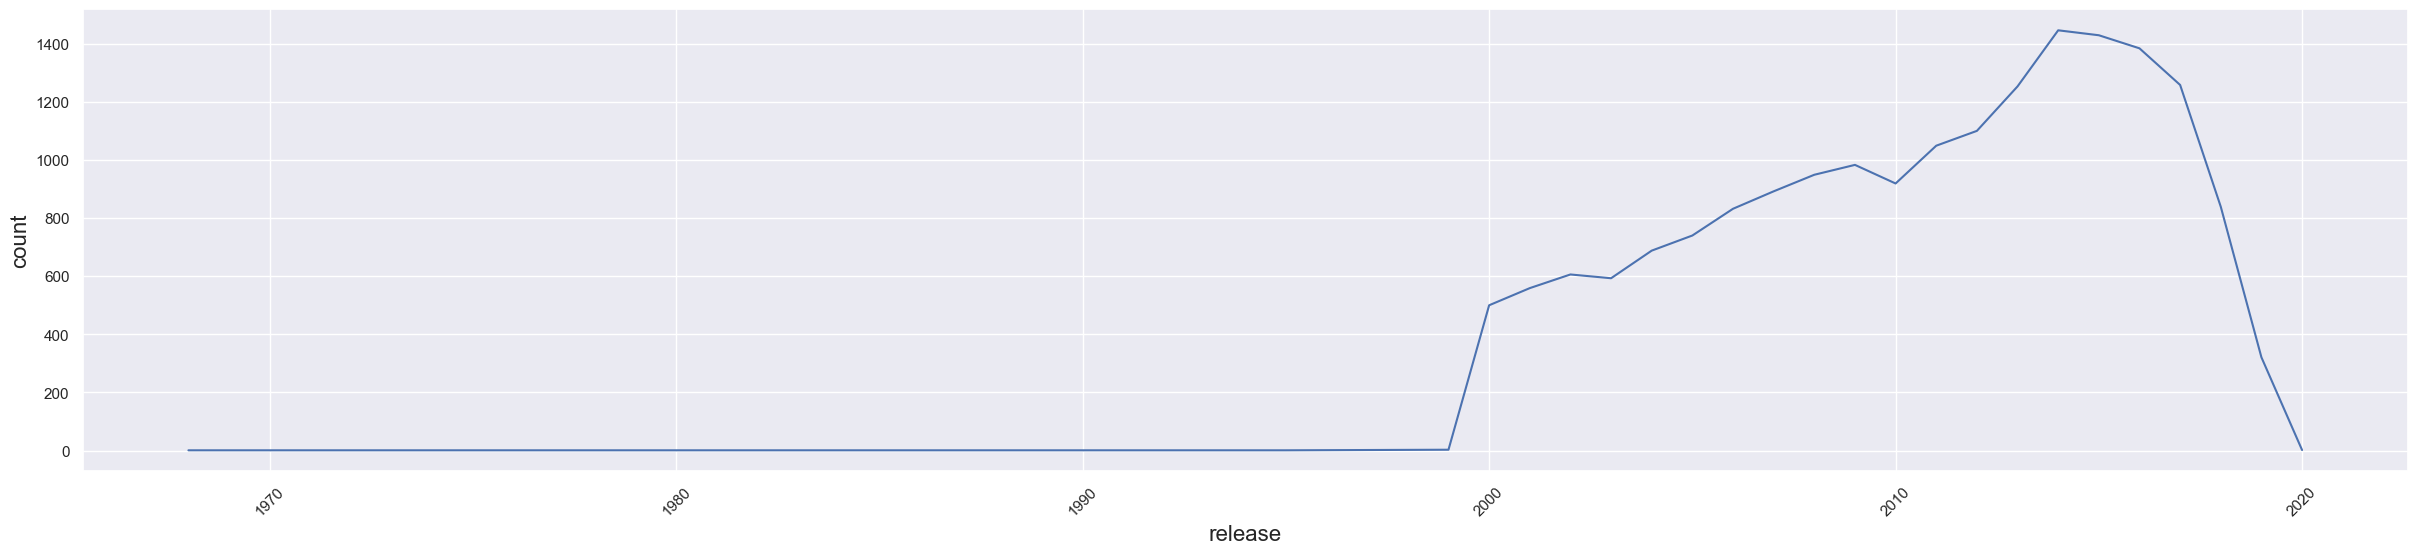

In [151]:
pl.lineplot(
    yearly_release_counts, 
    'release', 
    'count', 
    figsize=(30, 6),
    x_rotation=45
)

## ¿Cuantas peliculas se estrenaron por mes?

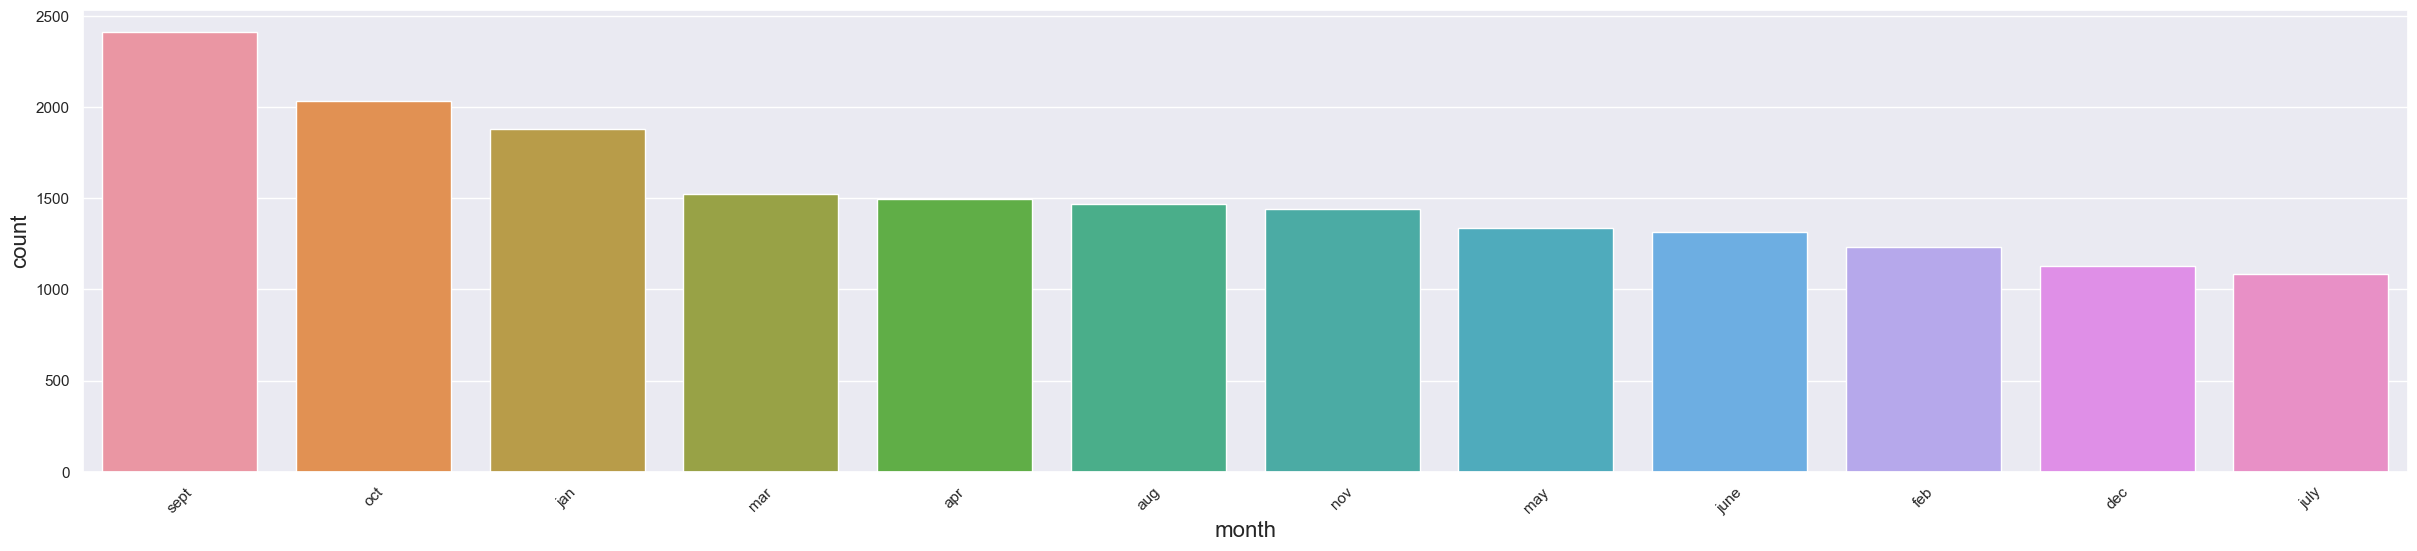

In [152]:
monthly_release_counts = movies3[movies3.release.dt.year >= 1970] \
    .groupby(movies3.release.dt.month) \
    .size() \
    .sort_values(ascending=False) \
    .reset_index(name='count')
    
monthly_release_counts['month'] = monthly_release_counts.release.apply(lambda it: dt.MONTHS[it-1])

pl.barplot(
    monthly_release_counts, 
    'month', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales son los dias de la seman preferidos para estrenar peliculas?

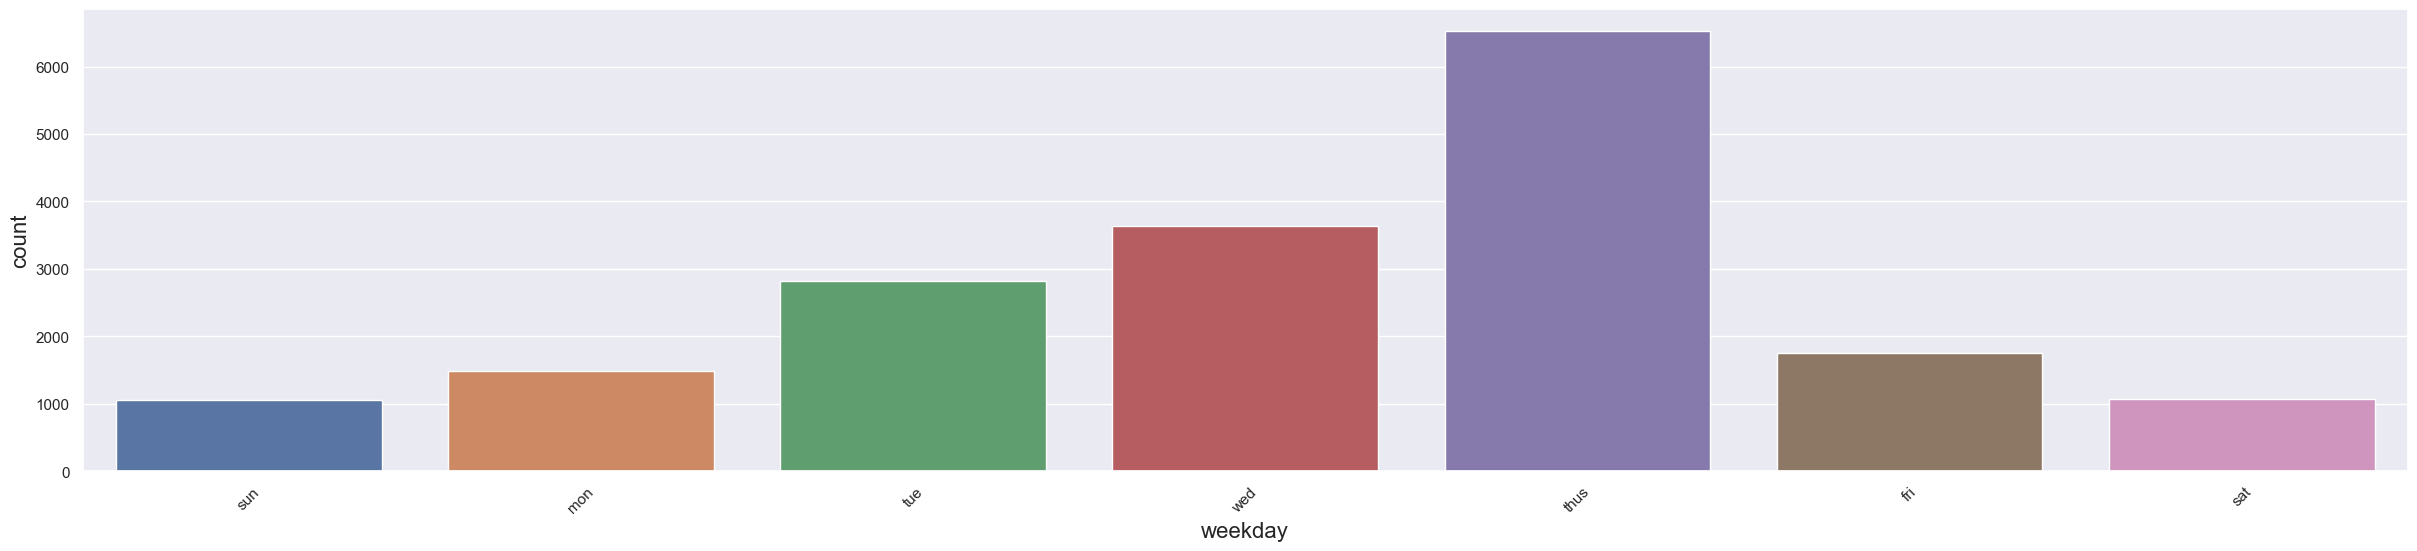

In [153]:
weekday_release_counts = movies3[movies3.release.dt.year >= 1970] \
    .groupby(movies3.release.dt.dayofweek) \
    .size() \
    .reset_index(name='count')
    
weekday_release_counts['weekday'] = weekday_release_counts \
    .release.apply(lambda it: dt.WEEK[it-1])


pl.barplot(
    weekday_release_counts, 
    'weekday', 
    'count', 
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor presupuesto?

In [155]:
# data = movies \
#    .sort_values(by=['budget'], ascending=False) \
#    [['title', 'budget']] \
#    [movies.budget > 0][:10]

# pl.barplot(
#    data, 
#    'title', 
#    'budget',
#    figsize=(30, 6), 
#    x_rotation=45
#)

## ¿Cuales cuales son las 10 peliculas con mayor popularidad?

/var/tmp/ipykernel_82438/1458916326.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies3 \


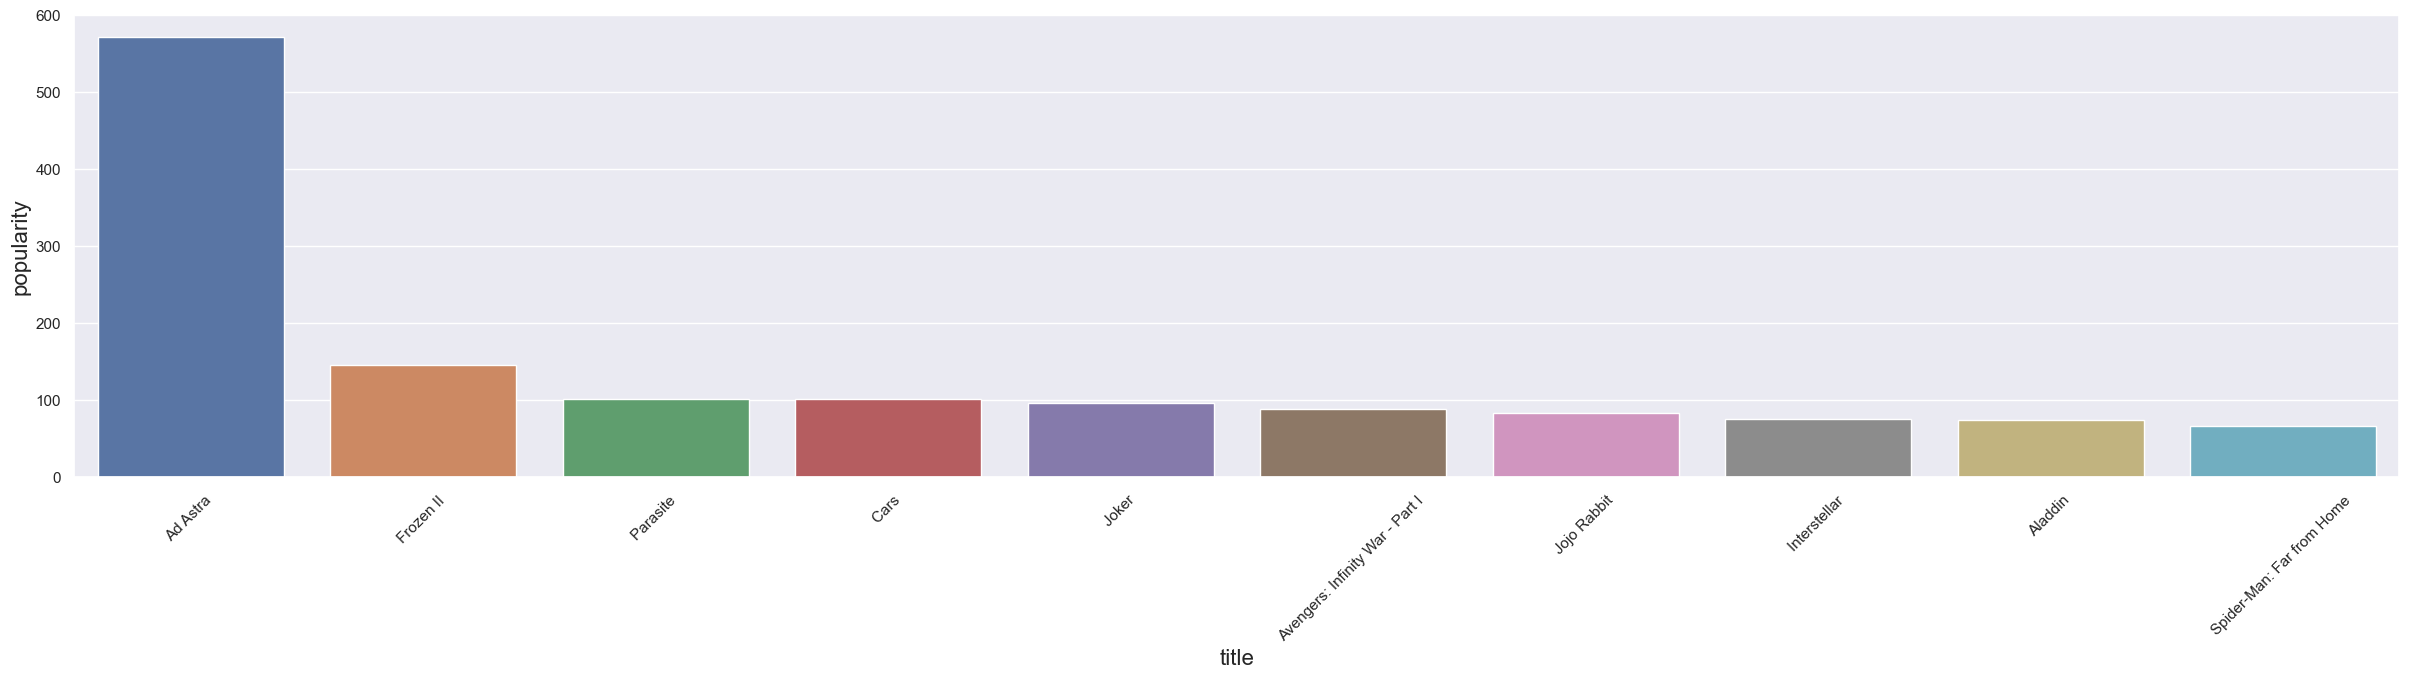

In [156]:
data = movies3 \
    .sort_values(by=['popularity'], ascending=False) \
    [['title', 'popularity']] \
    [movies3.popularity > 0][:10]

pl.barplot(
    data, 
    'title', 
    'popularity',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor promedio de votacion?

/var/tmp/ipykernel_82438/4246731389.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies3 \


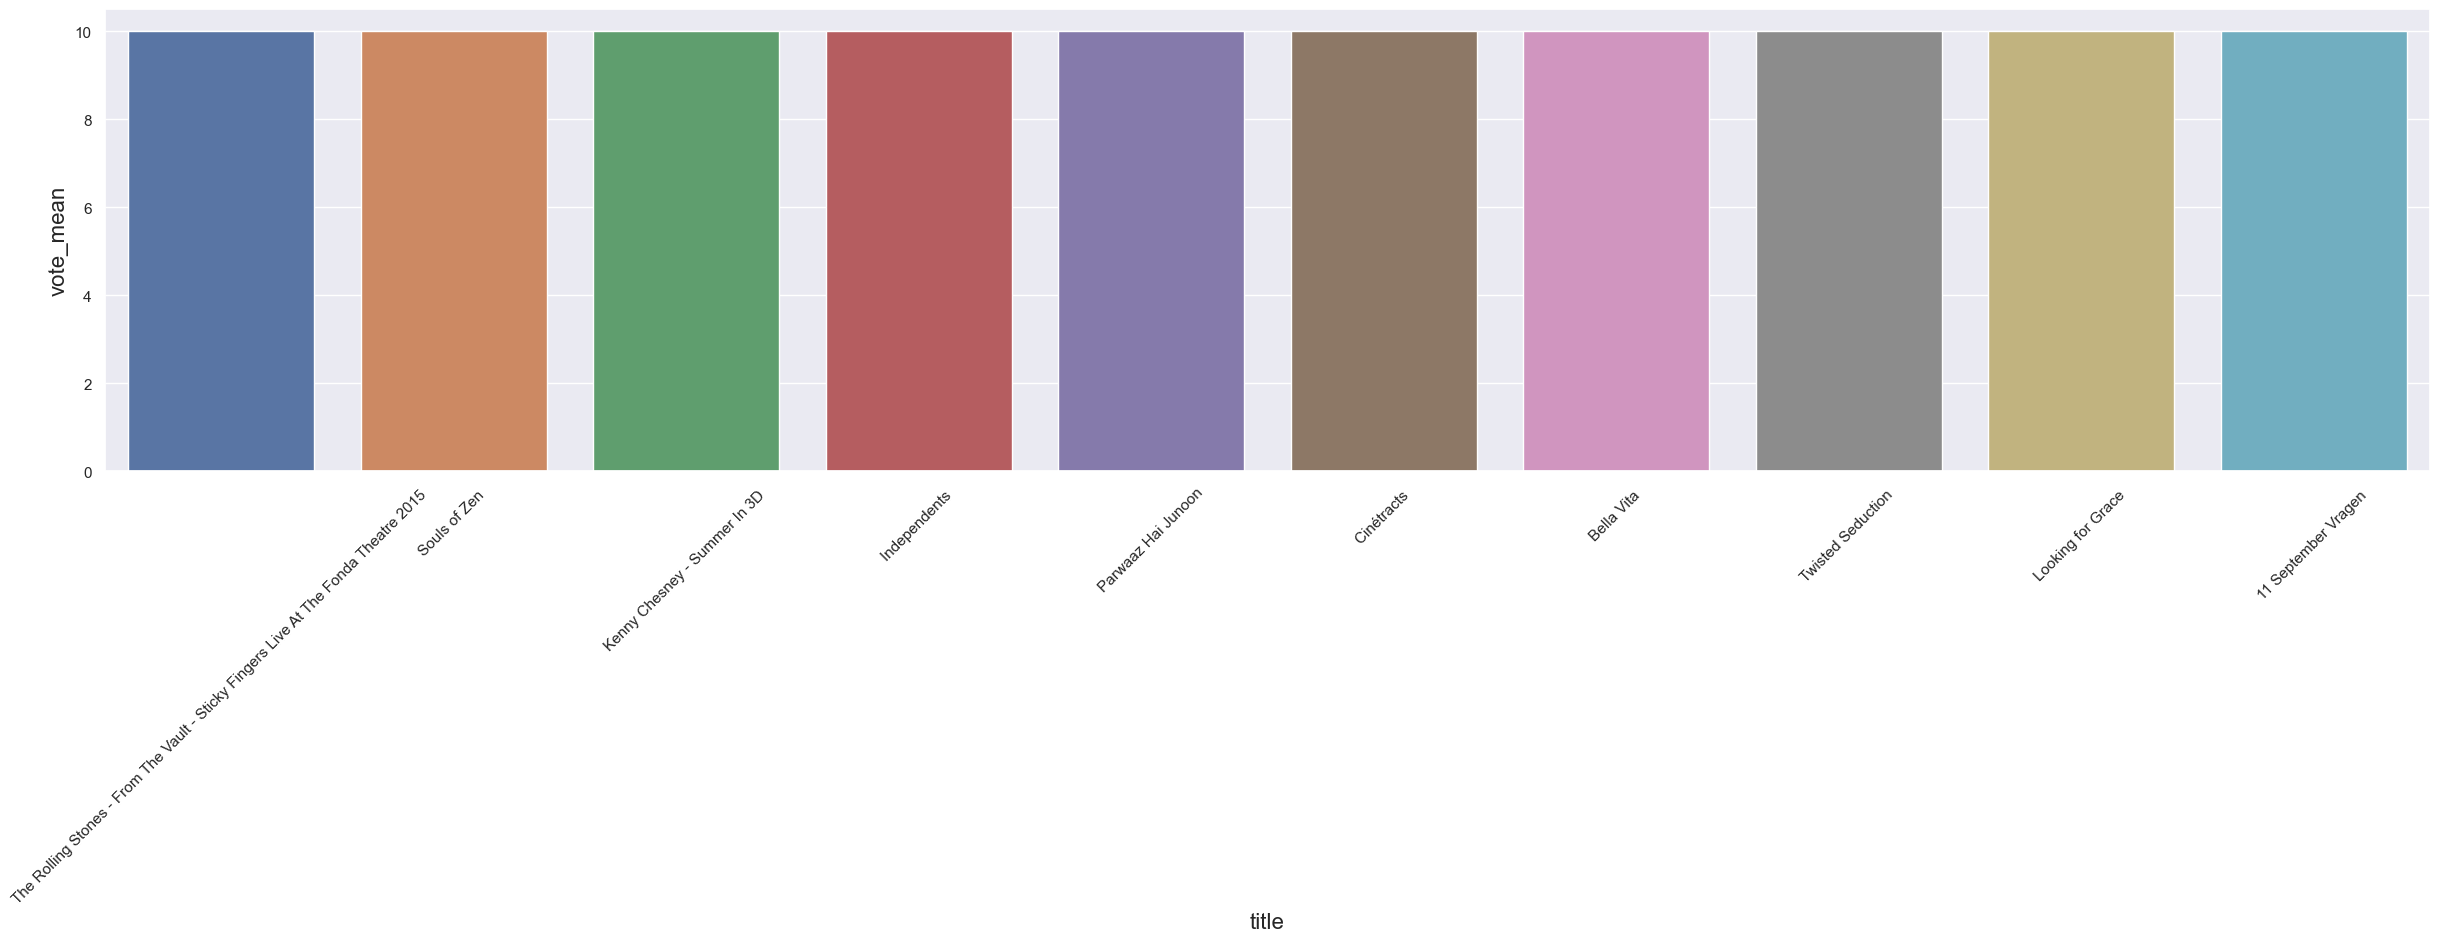

In [157]:
data = movies3 \
    .sort_values(by=['vote_mean'], ascending=False) \
    [['title', 'vote_mean']] \
    [movies3.vote_mean > 0][:10]

pl.barplot(
    data, 
    'title', 
    'vote_mean',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor cantidad de votaciones?

/var/tmp/ipykernel_82438/1707055543.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = movies3 \


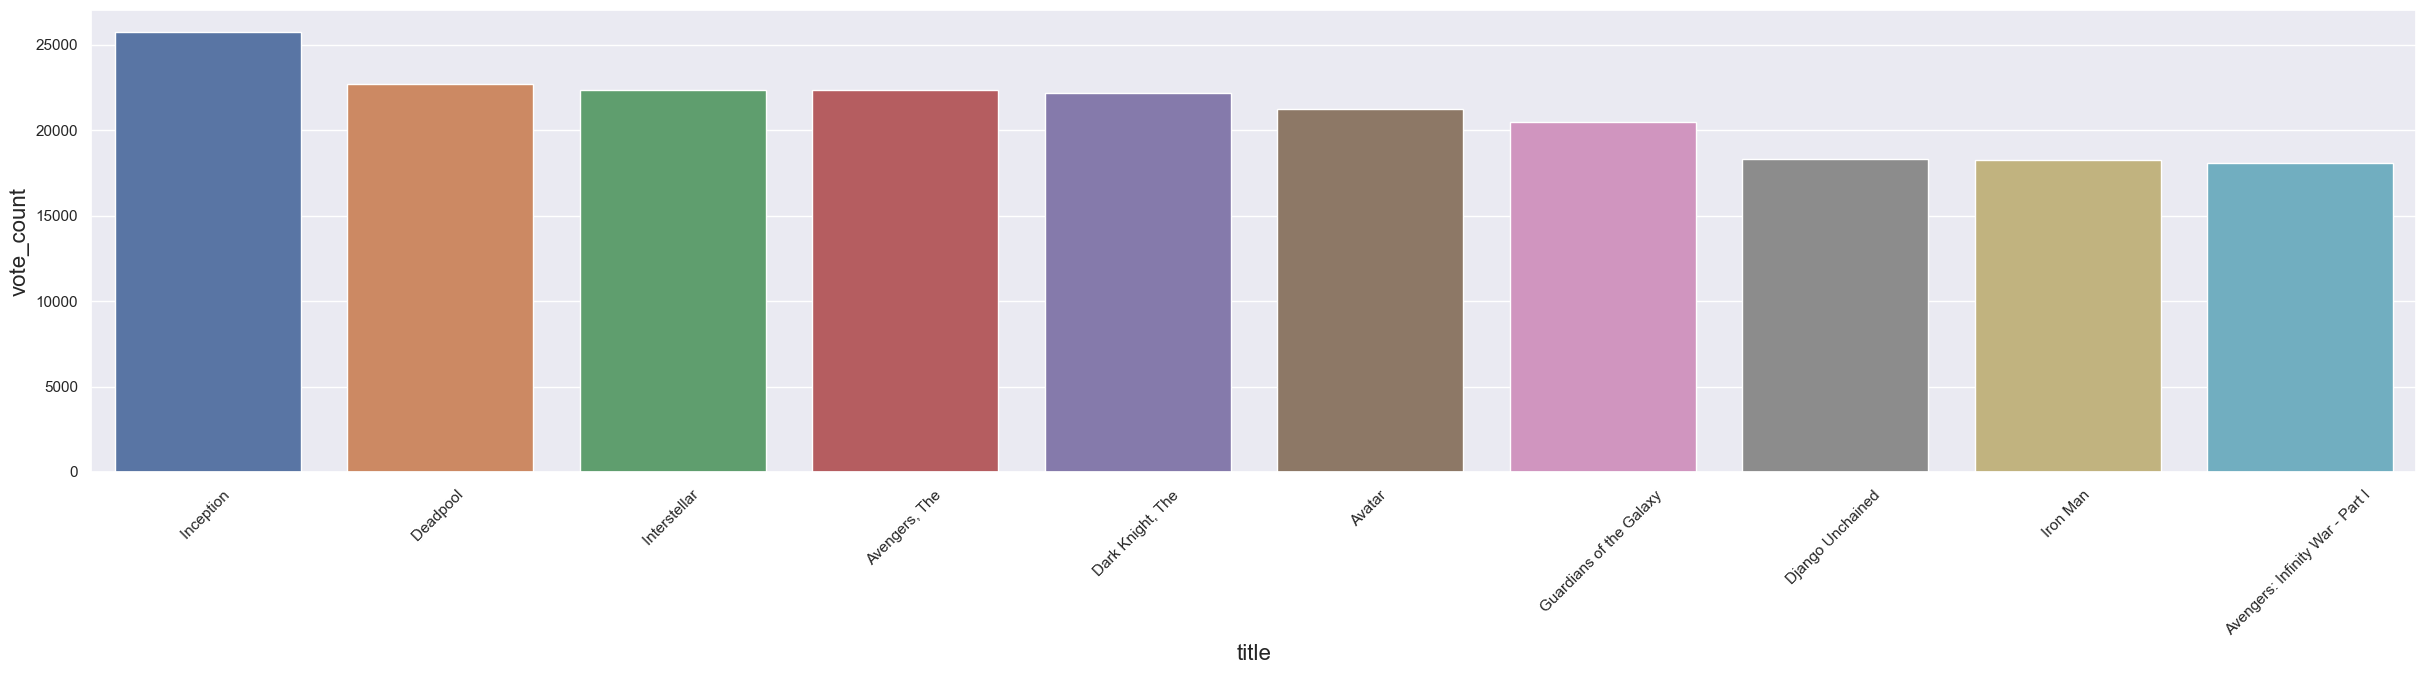

In [158]:
data = movies3 \
    .sort_values(by=['vote_count'], ascending=False) \
    [['title', 'vote_count']] \
    [movies3.vote_mean > 0][:10]

pl.barplot(
    data, 
    'title', 
    'vote_count',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor rating y votaciones?

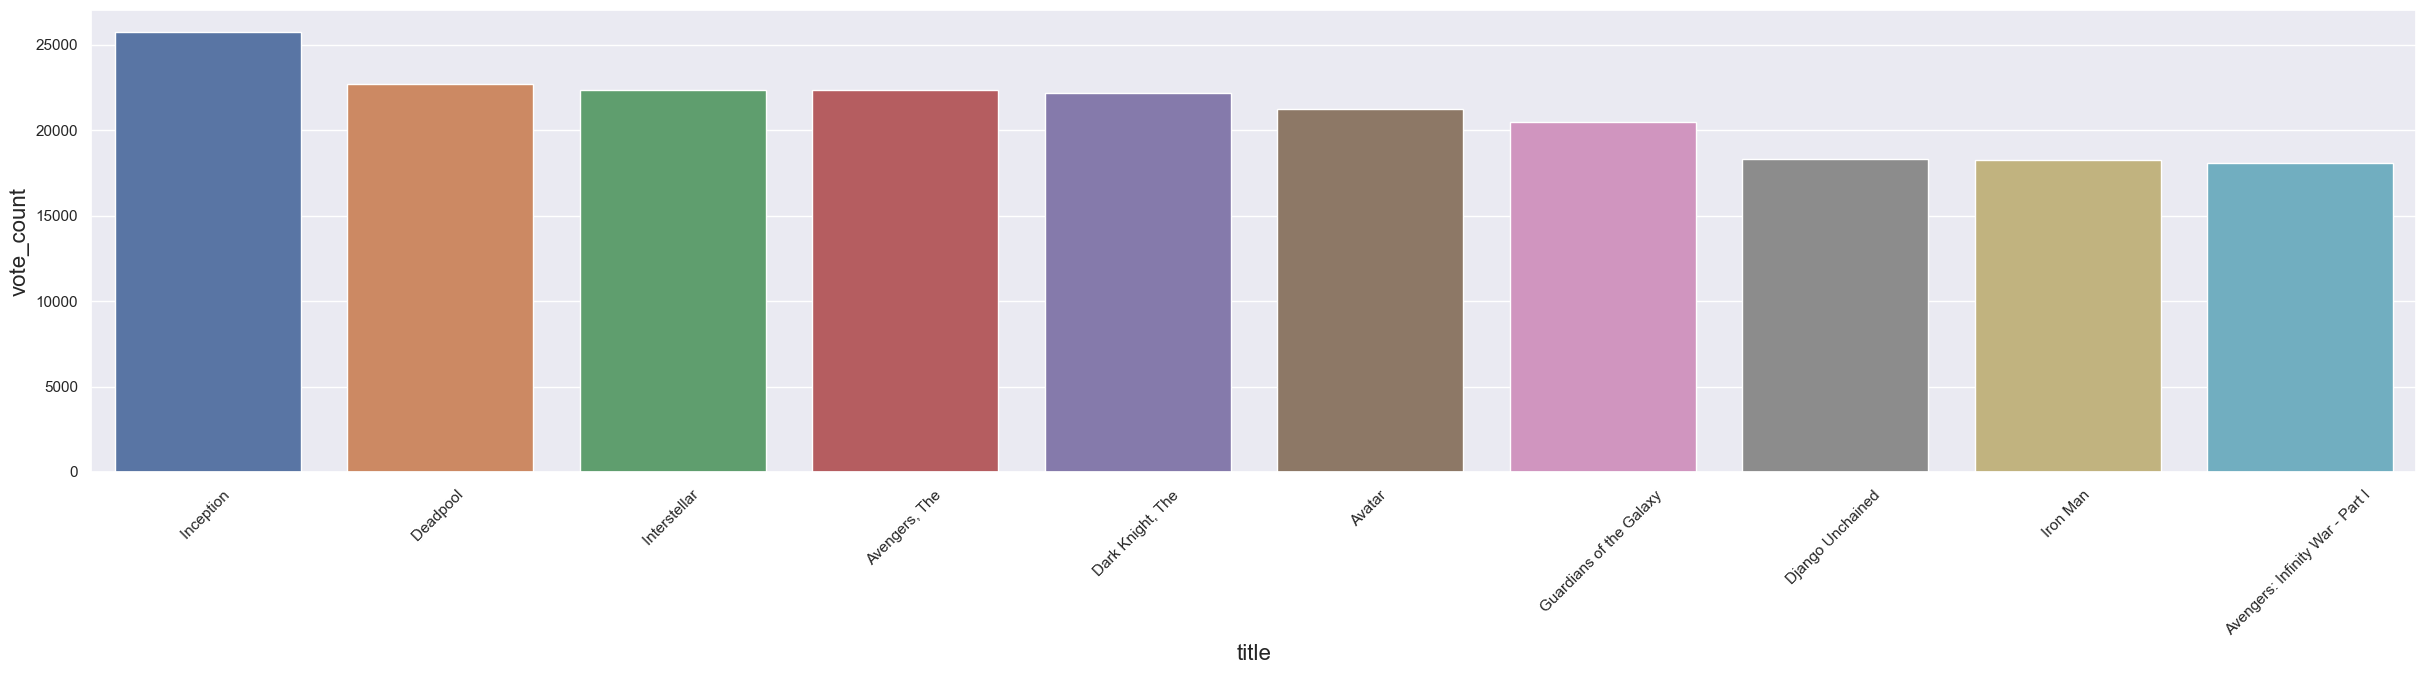

In [159]:
data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    ) \
    .sort_values(by=['rating', 'vote_count'], ascending=False) \
    [['title', 'rating', 'vote_count']] \
    .drop_duplicates() \
    [:10]

pl.barplot(
    data, 
    'title', 
    'vote_count',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cuales cuales son las 10 peliculas con mayor rating y popularidad?

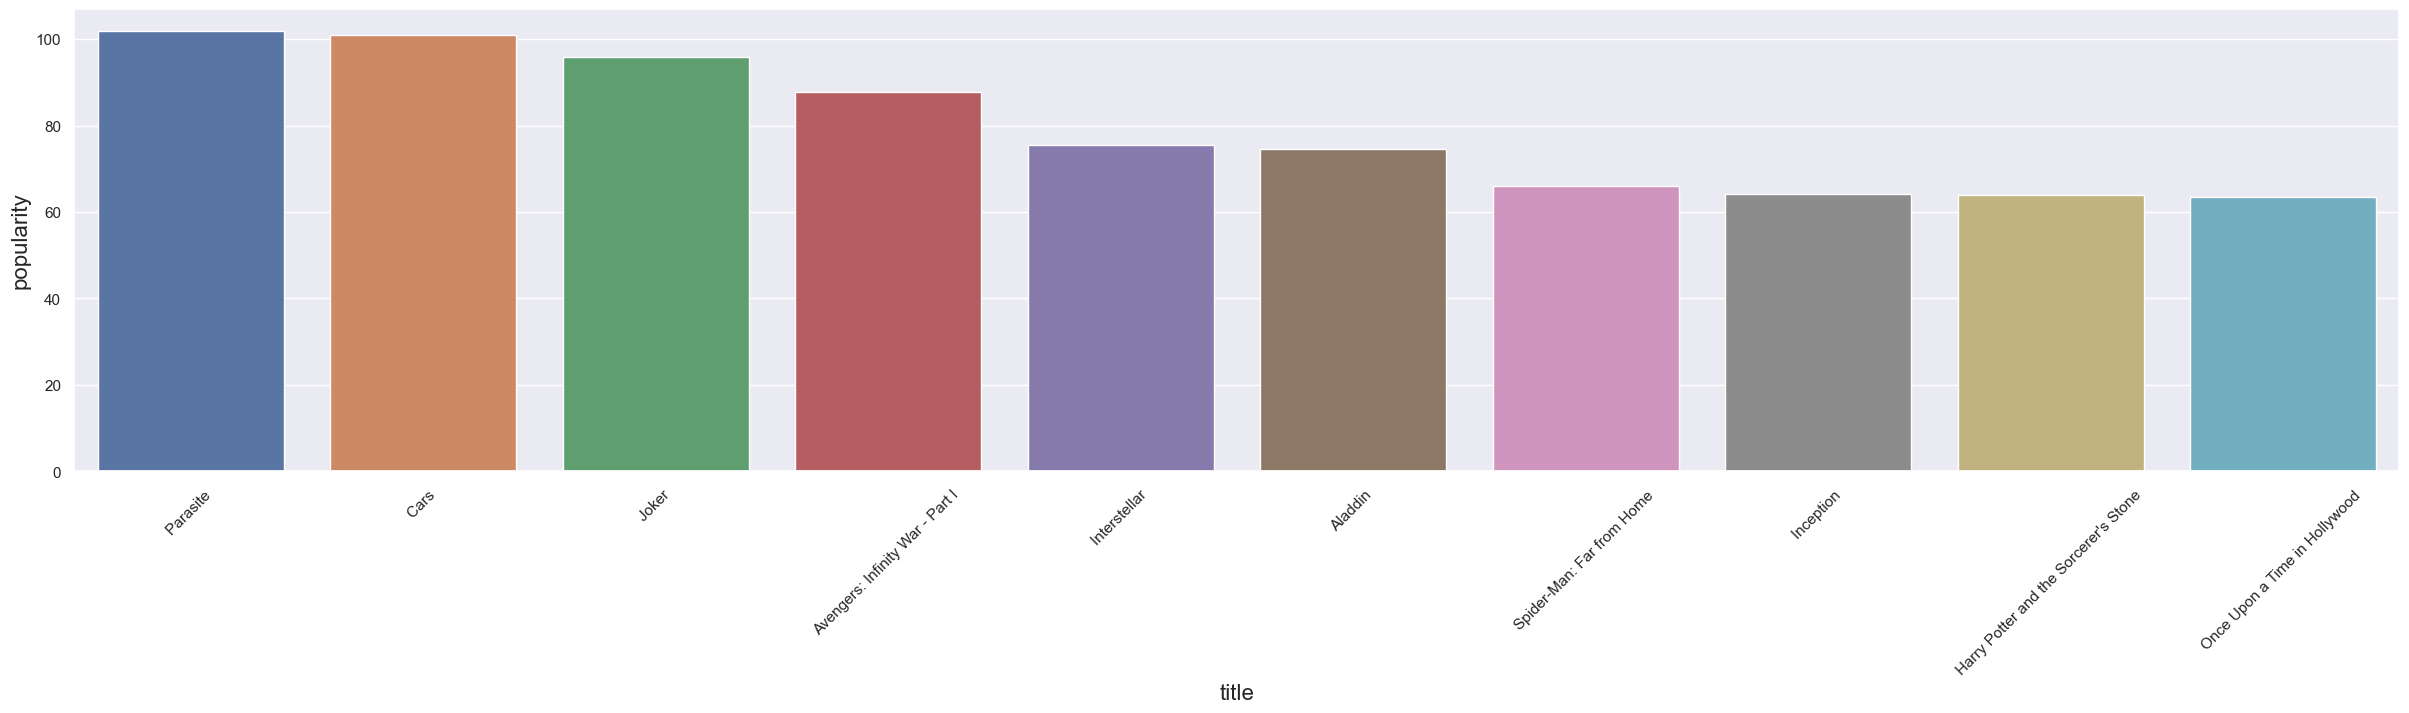

In [160]:
data = pd.merge(
        movies3,
        interactions,
        how='inner',
        left_on=['id'],
        right_on=['movie_id']
    ) \
    .sort_values(by=['rating', 'popularity'], ascending=False) \
    [['title', 'rating', 'popularity']] \
    .drop_duplicates() \
    [:10]

pl.barplot(
    data, 
    'title', 
    'popularity',
    figsize=(30, 6), 
    x_rotation=45
)

## ¿Cual es la cantidad de peliculas estranada por año para cada genero?

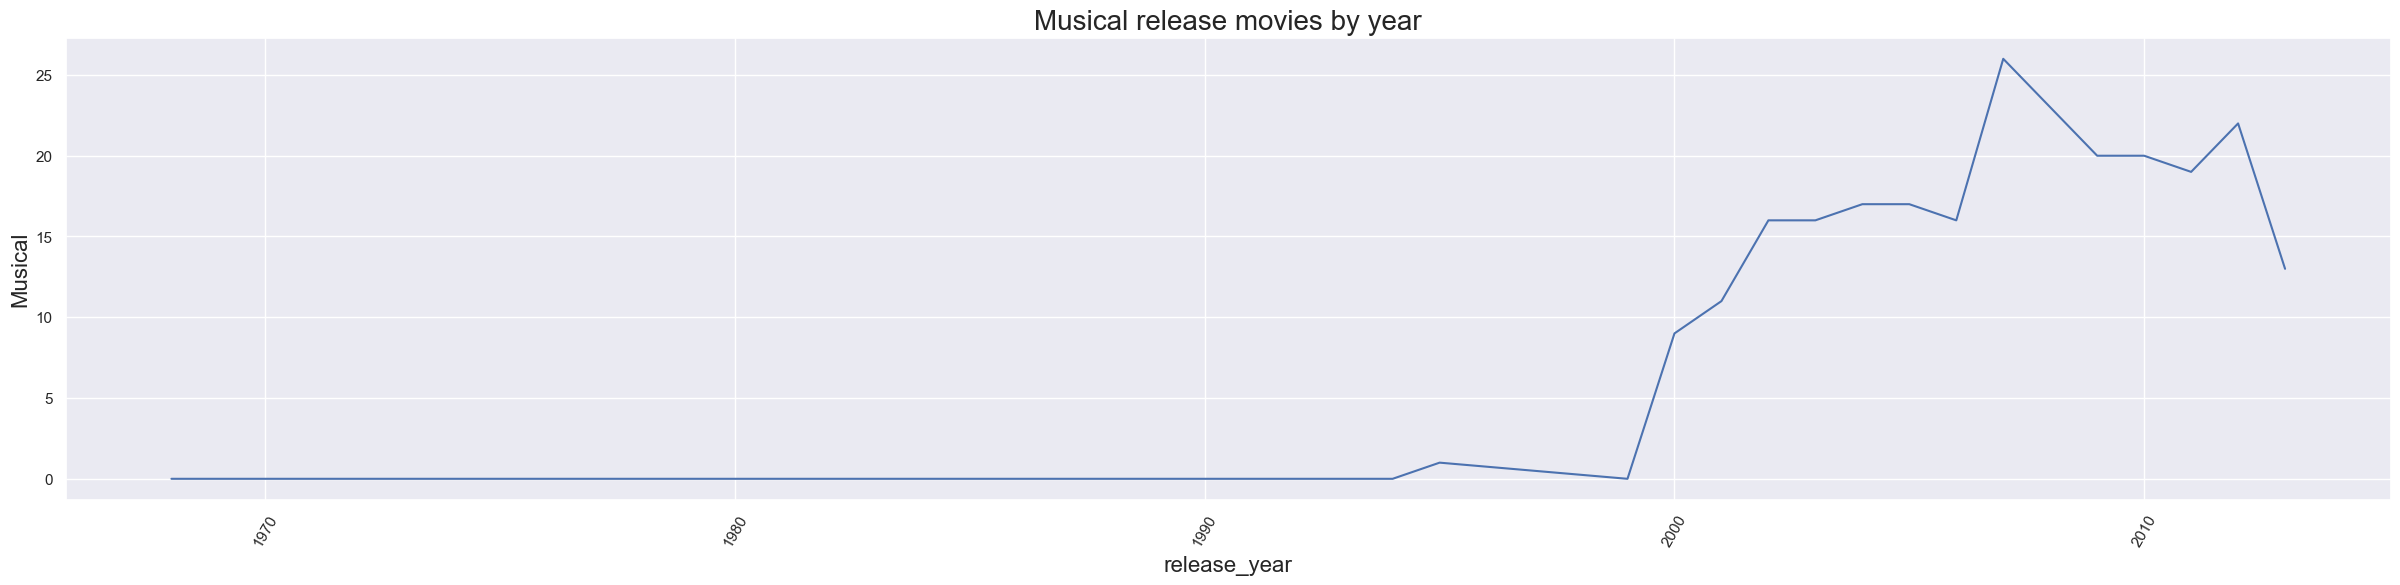

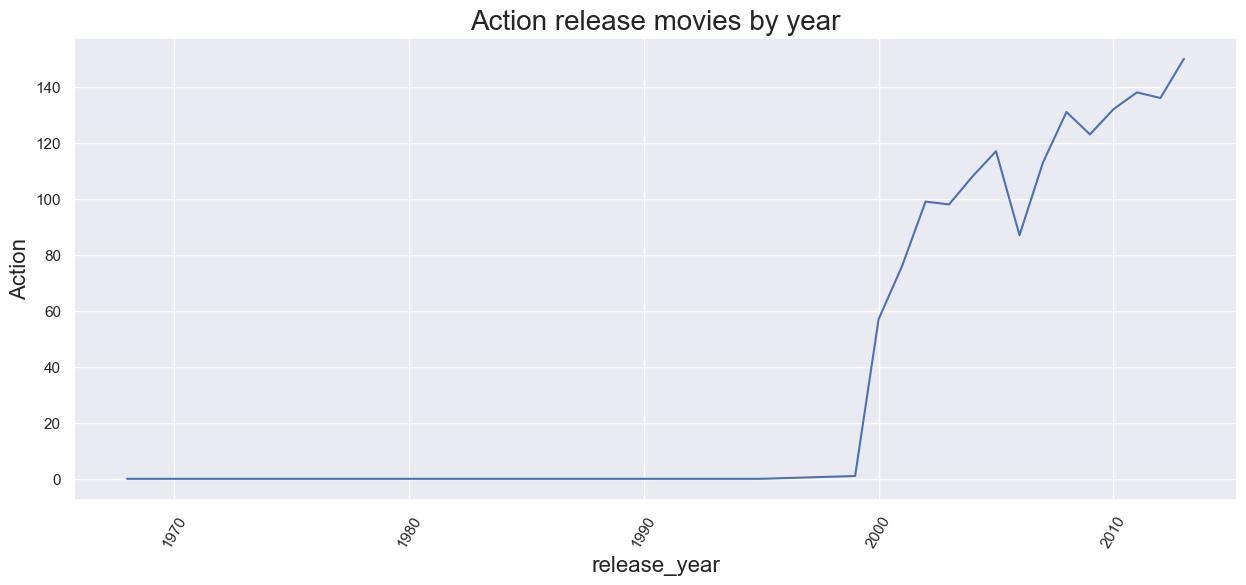

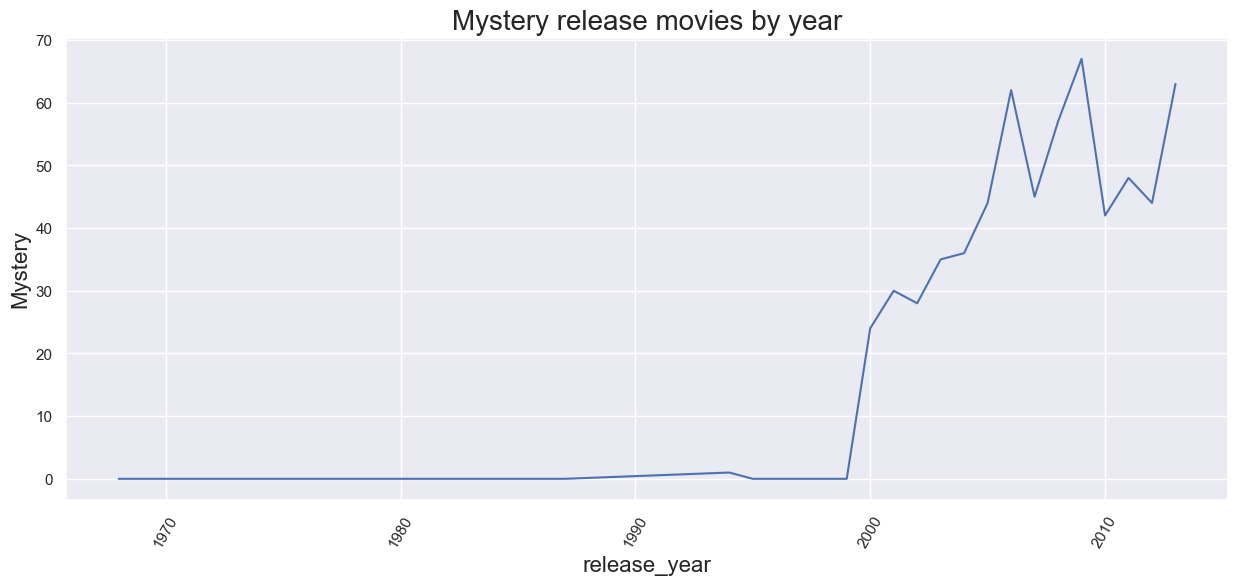

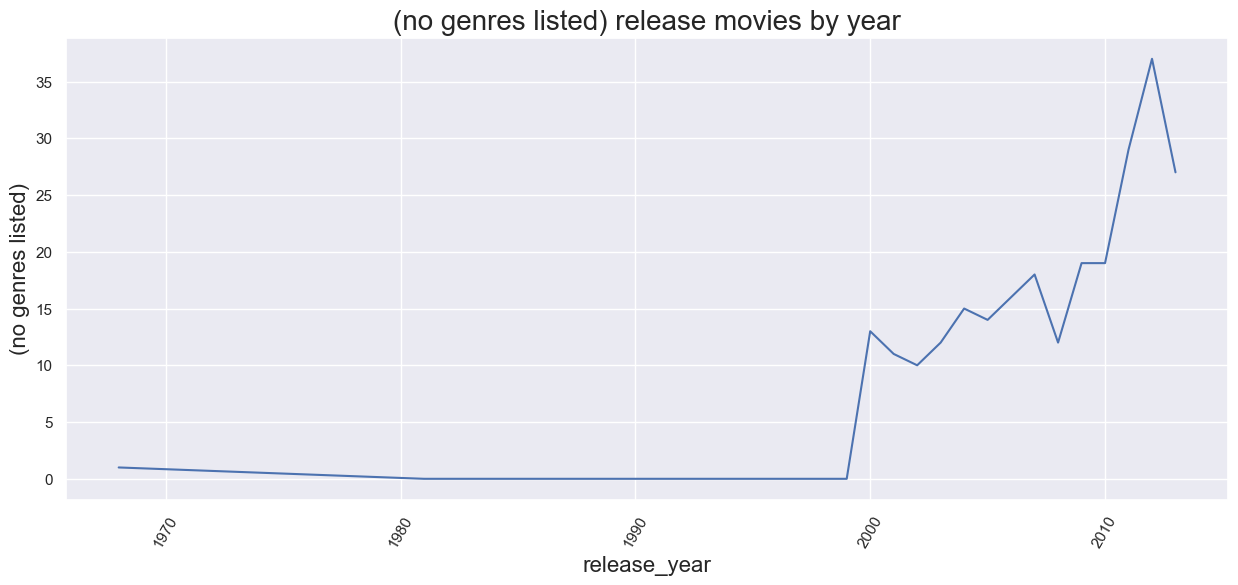

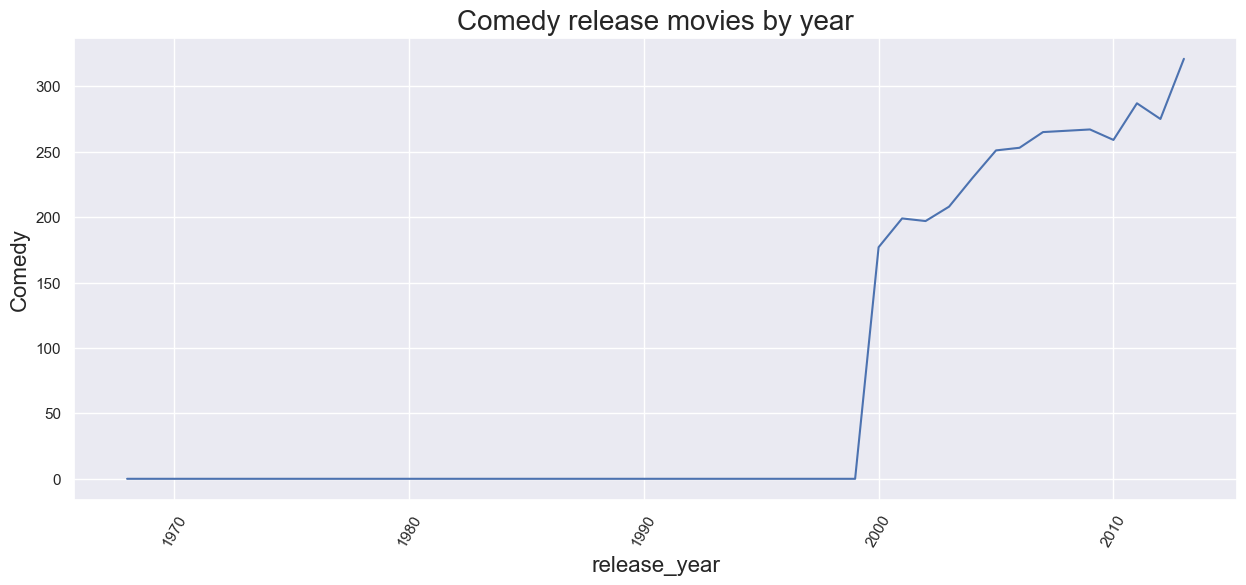

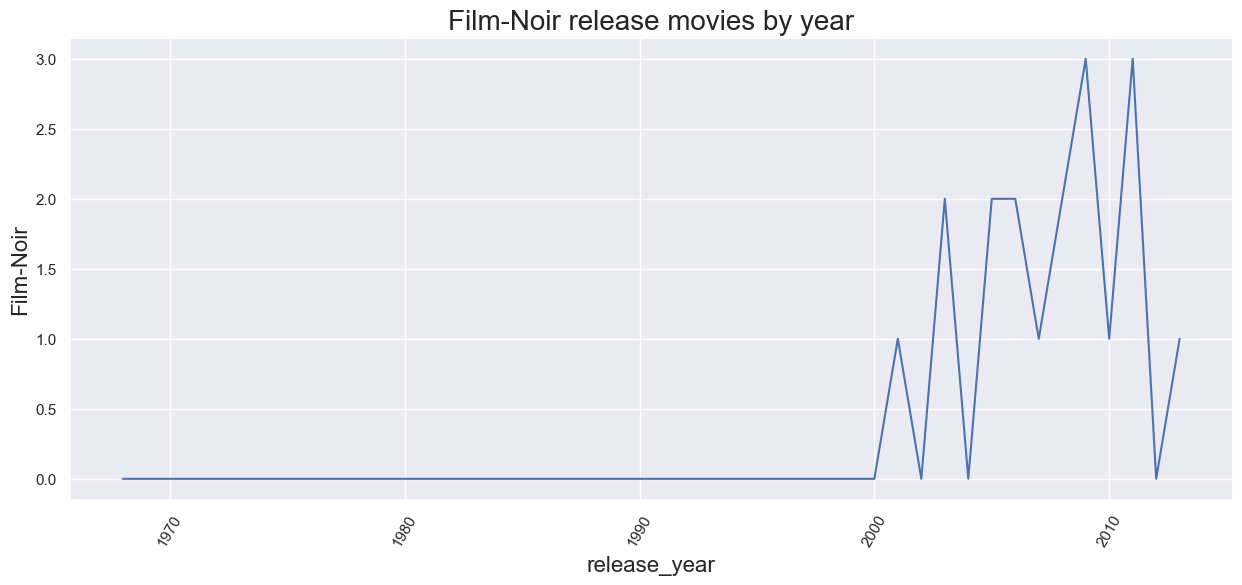

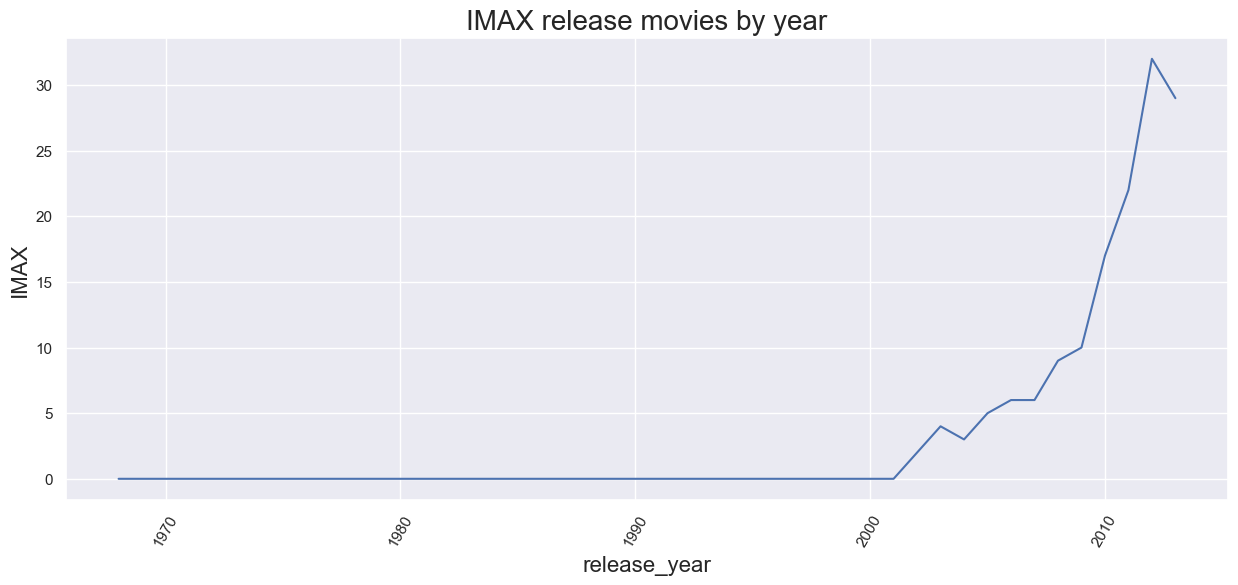

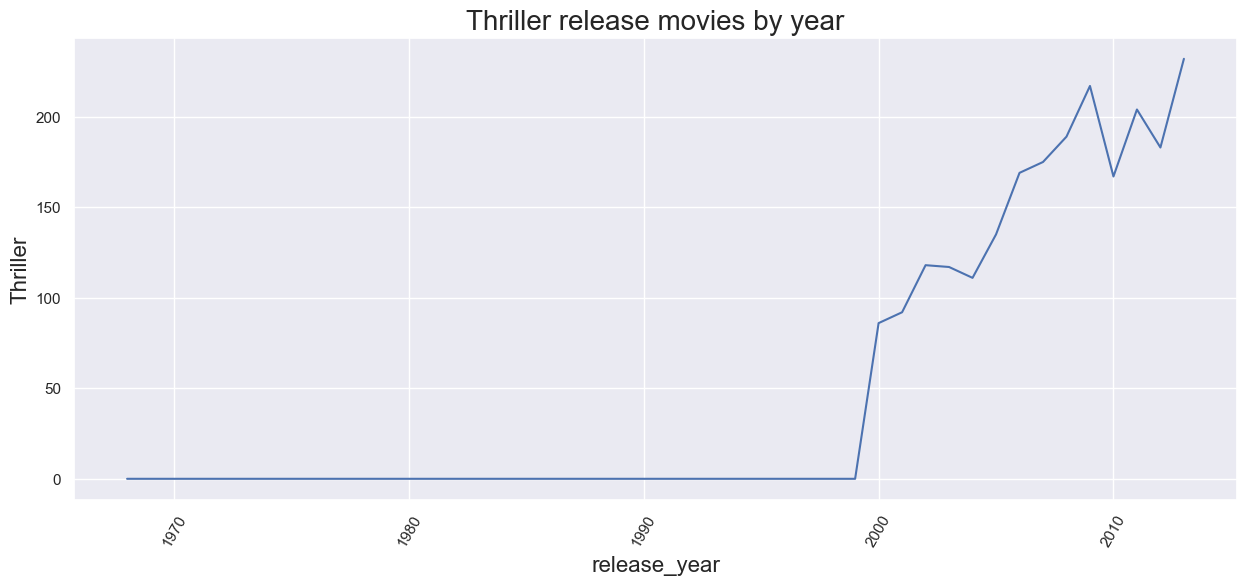

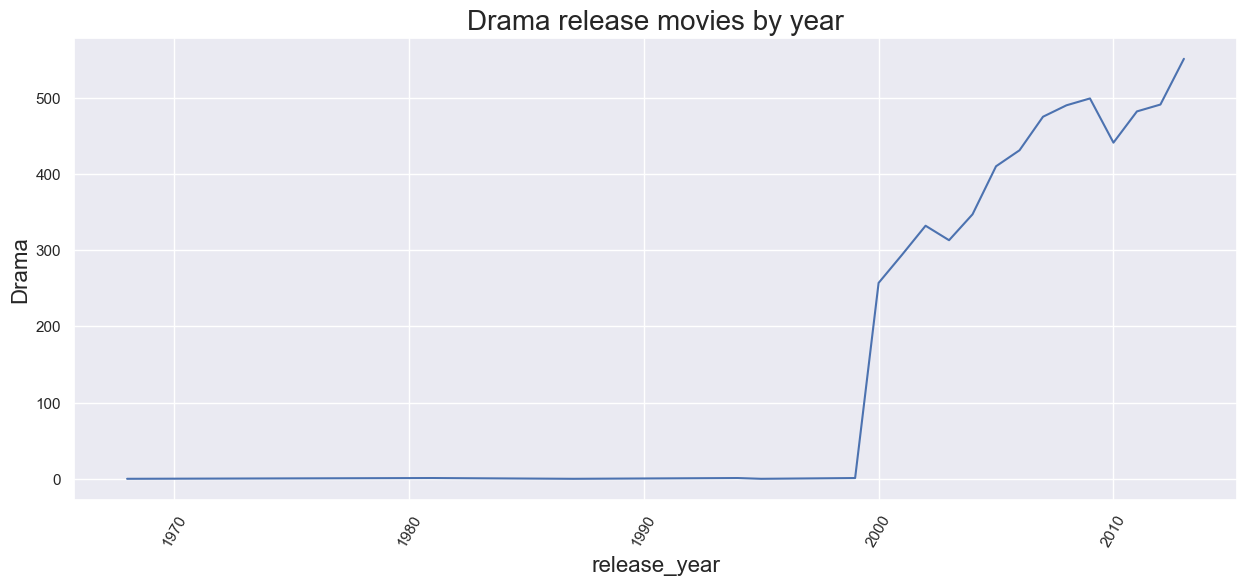

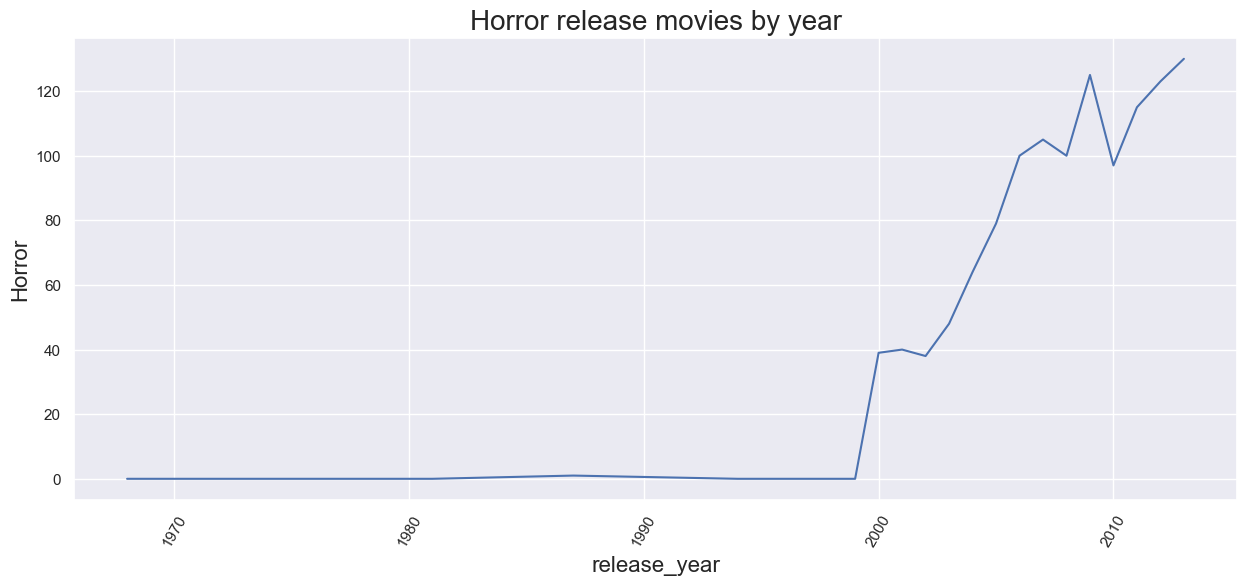

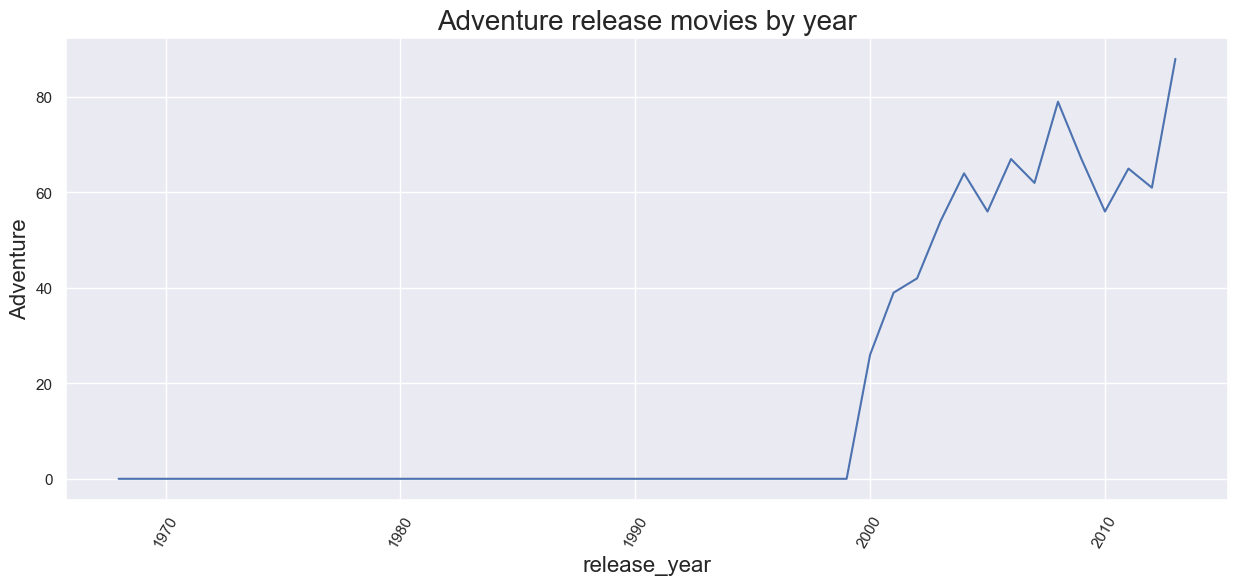

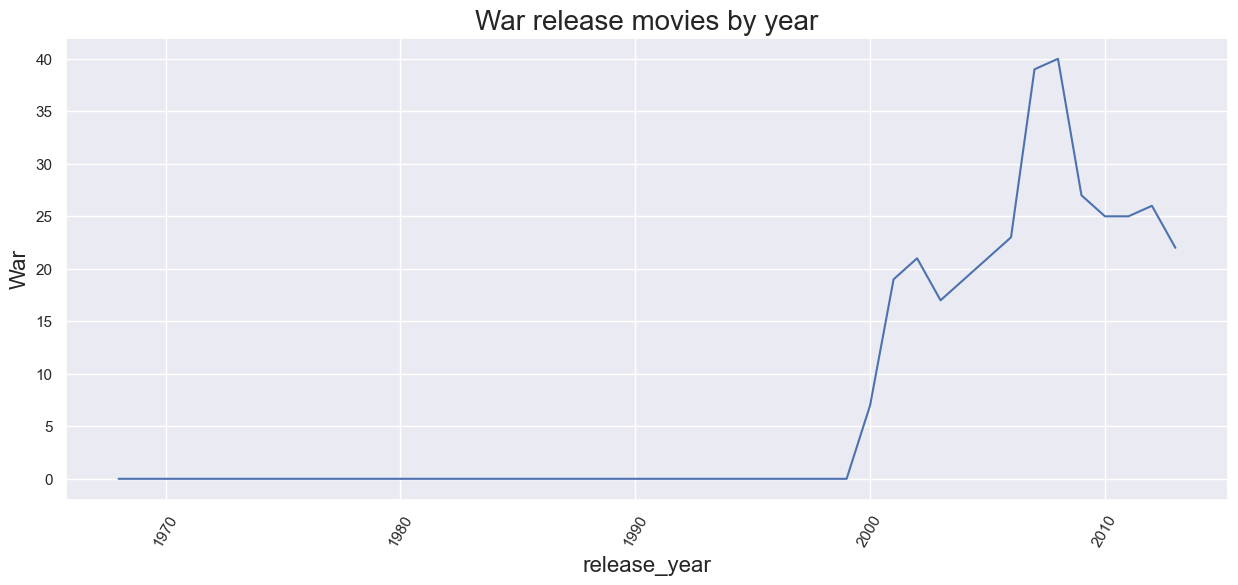

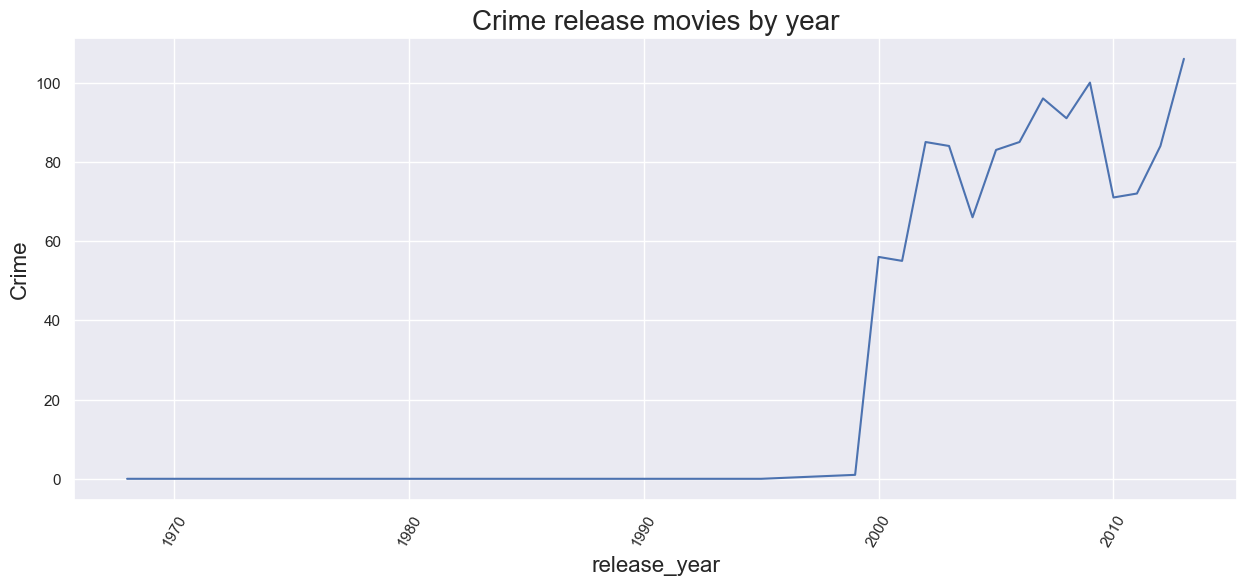

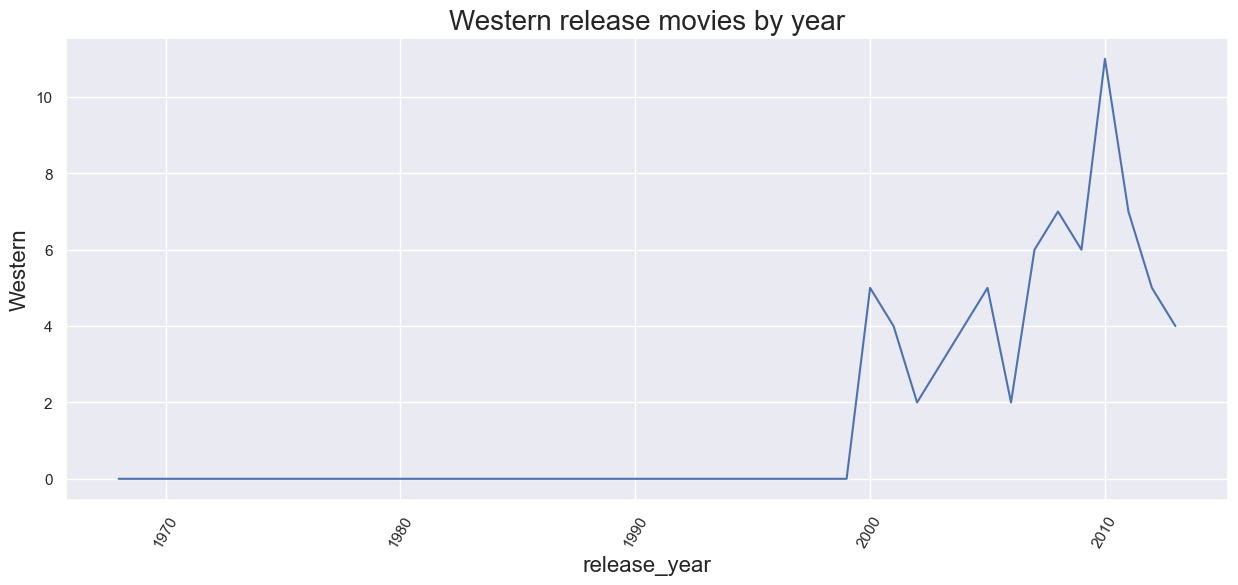

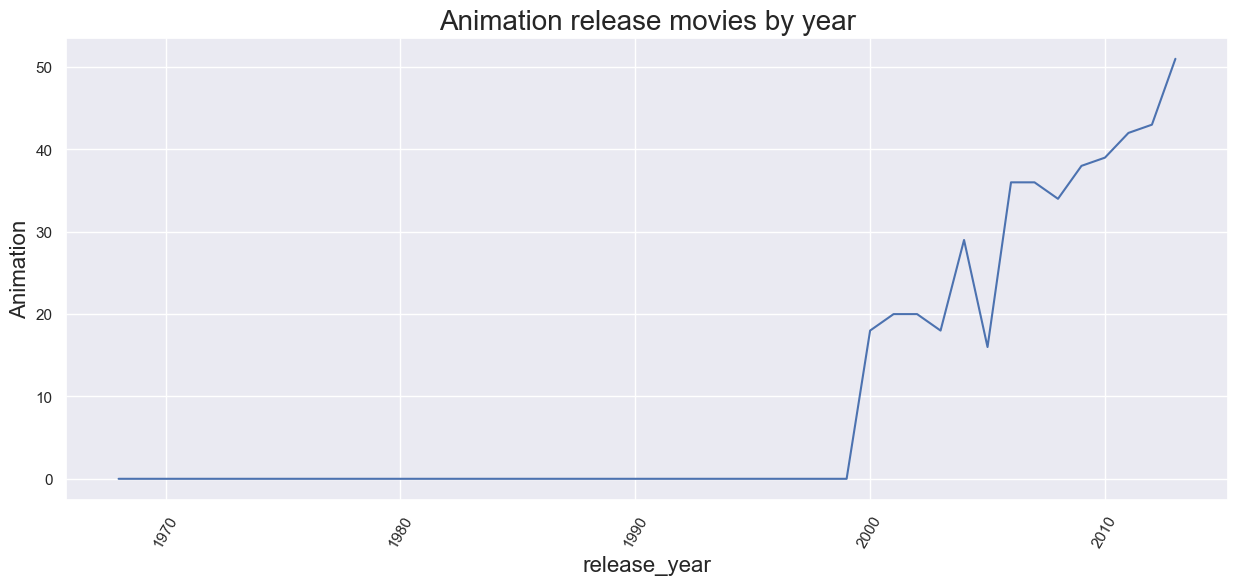

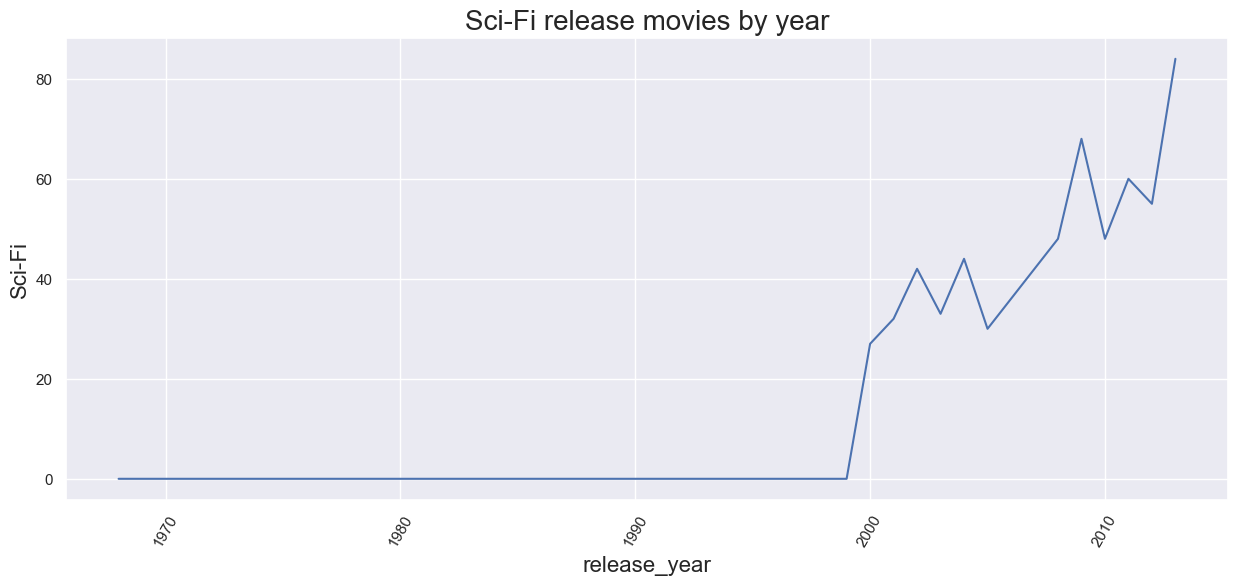

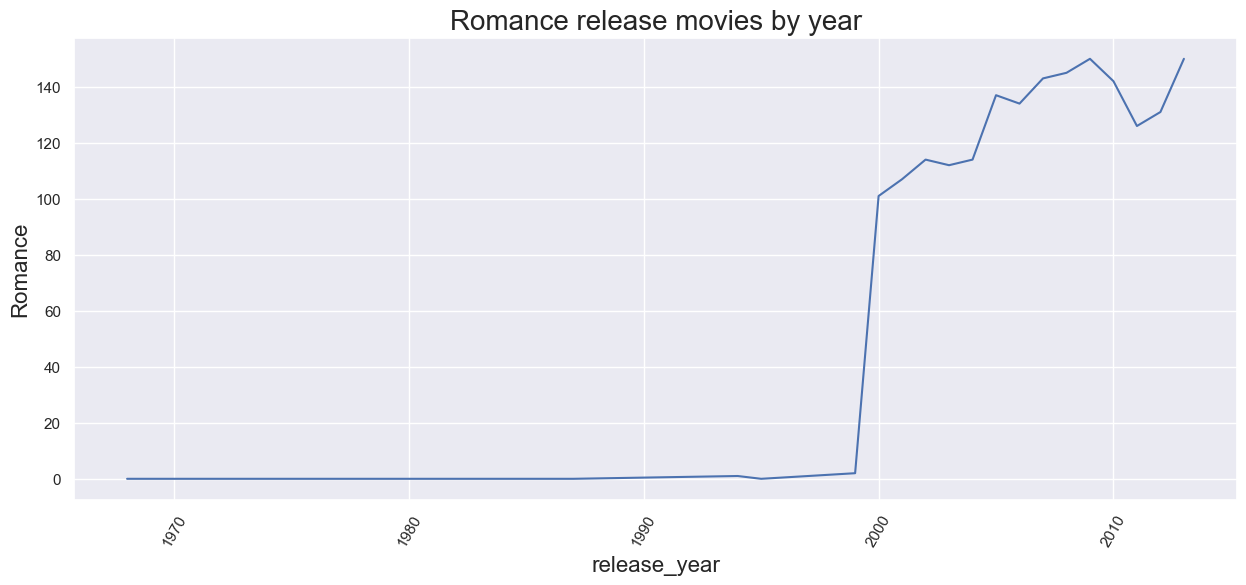

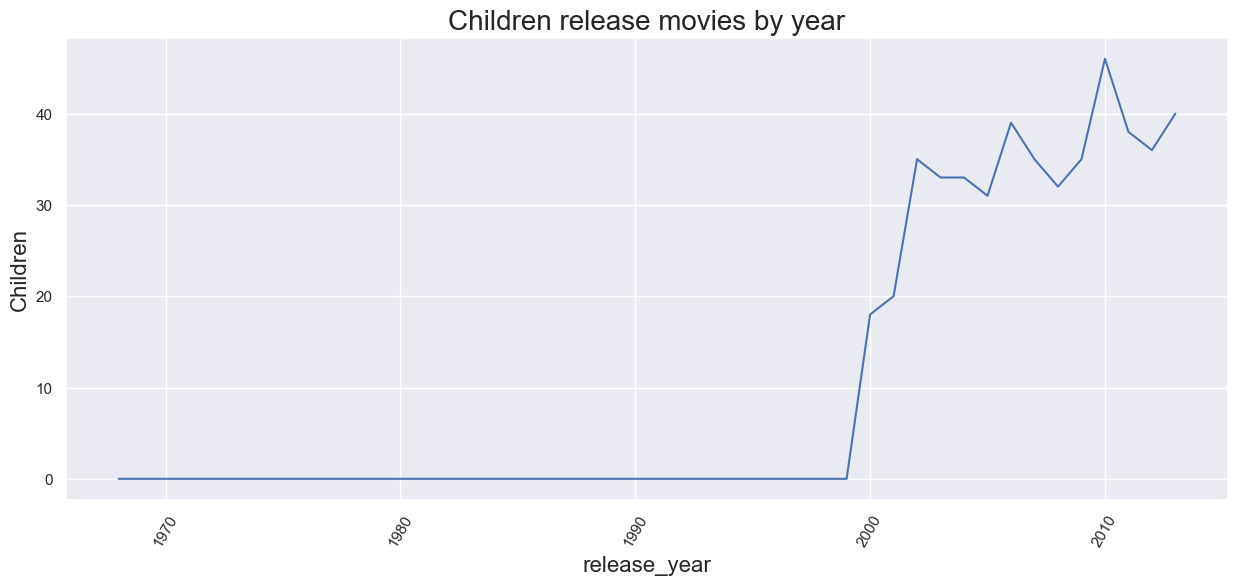

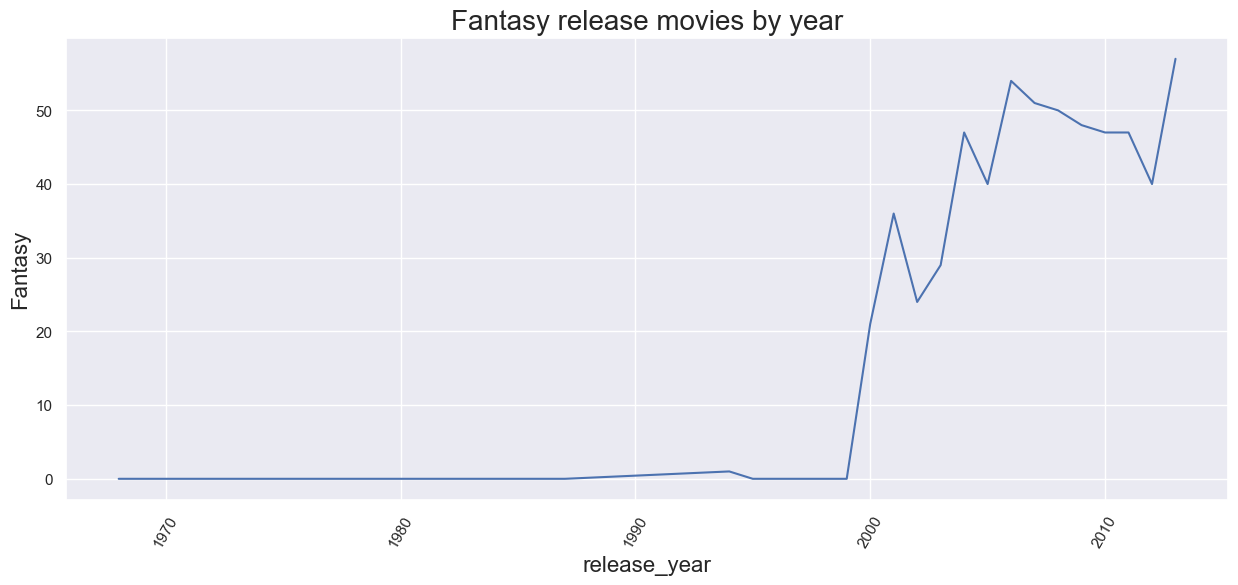

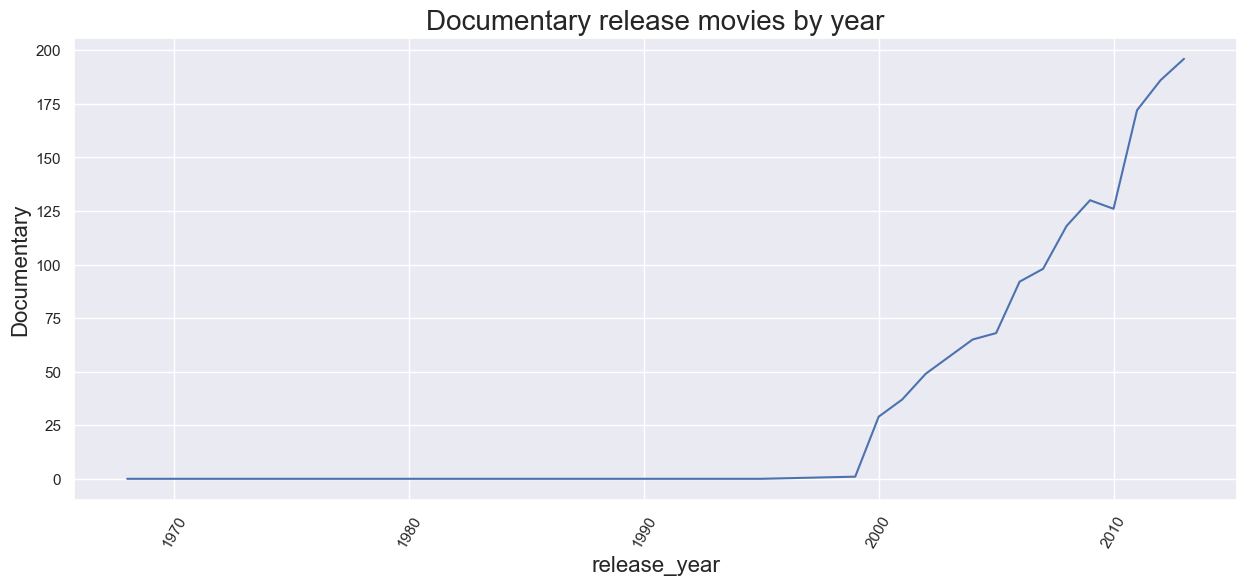

In [162]:
data = dt.list_column_to_dummy_columns(movies3, 'genres')

genres_columns = list(set(data.columns) - set(movies3.columns))

data = data[['release_year'] + genres_columns]

data = data[data['release_year'] <= 2013]


data = data[['release_year'] + genres_columns] \
    .groupby('release_year') \
    [genres_columns] \
    .sum() \
    .sort_values(by='release_year', ascending=True) \
    .reset_index()

[pl.lineplot(data, x='release_year', y=col, title=f'{col} release movies by year') for col in genres_columns]
None

In [163]:
interactions

rating           timestamp  user_id  movie_id  \
0          4.5 2015-07-27 21:07:28   100001       260   
1          4.5 2016-01-16 12:58:26   100016    111659   
2          2.0 2016-01-16 13:01:35   100016    112290   
3          5.0 2015-01-25 20:55:28   100016    114180   
4          4.5 2017-01-02 08:42:53   100016    117438   
...        ...                 ...      ...       ...   
210720     3.5 2013-09-09 15:28:53     9998    102903   
210721     5.0 2015-02-09 22:17:10     9998    112183   
210722     4.0 2012-08-01 17:48:28     9998      5418   
210723     2.5 2012-08-08 20:05:55     9998     58025   
210724     3.0 2013-03-05 22:24:45     9998     58103   

                                                     tags  year  
0       [adventure, classic, classic sci-fi, epic, joh...  2015  
1              [fairy tale, good vs evil, visual effects]  2016  
2                    [bad jokes, boring, horrible acting]  2016  
3            [amnesia, good acting, plot holes, survival]  2015  
4                              [beautiful, studio ghibli]  2017  
...                                                   ...   ...  
210720                               [pseudo-intelligent]  2013  
210721  [alter ego, edward norton, great performances,...  2015  
210722                  [assassin, espionage, matt damon]  2012  
210723  [concept, samuel l. jackson, silly, superhero,...  2012  
210724                                       [repetitive]  2013  

[210725 rows x 6 columns]

In [164]:
interactions = ut.datetime_to_seq(interactions, 'timestamp', 'rating_seq')
interactions

rating           timestamp  user_id  movie_id  \
0          4.5 2015-07-27 21:07:28   100001       260   
1          4.5 2016-01-16 12:58:26   100016    111659   
2          2.0 2016-01-16 13:01:35   100016    112290   
3          5.0 2015-01-25 20:55:28   100016    114180   
4          4.5 2017-01-02 08:42:53   100016    117438   
...        ...                 ...      ...       ...   
210720     3.5 2013-09-09 15:28:53     9998    102903   
210721     5.0 2015-02-09 22:17:10     9998    112183   
210722     4.0 2012-08-01 17:48:28     9998      5418   
210723     2.5 2012-08-08 20:05:55     9998     58025   
210724     3.0 2013-03-05 22:24:45     9998     58103   

                                                     tags  year  rating_seq  
0       [adventure, classic, classic sci-fi, epic, joh...  2015      119237  
1              [fairy tale, good vs evil, visual effects]  2016      132268  
2                    [bad jokes, boring, horrible acting]  2016      132270  
3            [amnesia, good acting, plot holes, survival]  2015      108996  
4                              [beautiful, studio ghibli]  2017      149346  
...                                                   ...   ...         ...  
210720                               [pseudo-intelligent]  2013       94823  
210721  [alter ego, edward norton, great performances,...  2015      109563  
210722                  [assassin, espionage, matt damon]  2012       82592  
210723  [concept, samuel l. jackson, silly, superhero,...  2012       82725  
210724                                       [repetitive]  2013       89069  

[210725 rows x 7 columns]

Cuantas interacciones se realizaron en un mismo momento en el tiempo?

In [165]:
df_tmp = interactions \
    .groupby(['timestamp', 'rating_seq']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(['count'], ascending=False)

df_tmp[df_tmp['count'] > 20]

timestamp  rating_seq  count
154274 2017-03-29 03:31:35      154275    210
154273 2017-03-29 03:31:34      154274    161
154275 2017-03-29 03:31:36      154276     42
166490 2017-12-04 22:08:02      166491     27
157151 2017-05-21 02:40:28      157152     26
172666 2018-03-19 06:25:54      172667     23

In [166]:
movies3.to_json(f'{DATASETS_PATH}/movies.json')
interactions.to_json(f'{DATASETS_PATH}/interactions.json')

### References

* https://www.kaggle.com/code/amar09/eda-recommendation-model-on-movielens-100k/notebook
* https://jovian.ai/surendranjagadeesh/movielens-eda